### Main Plots and tables

In [11]:
# Main table of the paper

import pandas as pd
import numpy as np

df = pd.read_csv('results/combined_scores.csv')

# Filter dataset
df = df[df['n_components'] == 3]
df = df[df['layer'] > 2]
df = df[df['target_col'] == 'last_prompt_token']  # Only consider last prompt token
df = df[(df['dataset_name'] != 'duration_3way') | (df['preprocess_func'].isna())]  # Exclude duration_3way dataset if preprocess_func is NaN
df = df[~((df['dataset_name'] == 'date_3way_season') & (df['label_col'] == 'correct_date'))]

# df = df[df['target_col'] == 'last_prompt_token']
# df = df[~df['manifold'].isin(['log_semicircular'])]

# df = df[~df['dataset_name'].isin(['date_3way_season', 'date_3way_temperature', 'time_of_day_3way_phase'])]
df = df[~df['dataset_name'].isin(['date_3way_temperature'])] # Stress computation breaks down for binary datasets - an indicator of structure in itself
df['score'] = - np.log(1 - df['score'])  # Convert score to stress (1 - score)

# Step 0: Rename
df['model_name'] = df['model_name'].str.split('/').str[-1]
df['dataset_name'] = df['dataset_name'].str.replace('_3way', '', regex=False).replace('_','\\_')

# Step 1: For each (model, dataset, manifold), get the best (layer, score)
best_per_manifold = df.loc[df.groupby(['model_name', 'dataset_name', 'manifold'])['score'].idxmax()]

# Step 2: For each (model, dataset), get top 3 **distinct** manifolds based on their best layer scores
top_k = best_per_manifold.groupby(['model_name', 'dataset_name'], group_keys=False).apply(
    lambda g: g.nlargest(3, 'score')
)

# Step 3: Add rank (1=best manifold, etc.)
top_k['rank'] = top_k.groupby(['model_name', 'dataset_name']).cumcount() + 1

# Optional: pivot for easier comparison
pivoted = top_k.pivot_table(
    index=['dataset_name', 'model_name', 'accuracy', 'target_col'],
    columns='rank',
    values=['manifold', 'score'],
    aggfunc='first'
)

# Flatten multi-index columns
pivoted.columns = [f'{col[0]}_top{col[1]}' for col in pivoted.columns]
pivoted = pivoted.reset_index()
# Reorder columns to be manifold1 score1, manifold2 score2, etc.
pivoted = pivoted[['dataset_name', 'model_name', 'target_col', 'accuracy'] + 
                  ['manifold_top1', 'score_top1', 
                   'manifold_top2', 'score_top2', 
                   'manifold_top3', 'score_top3']]

# --- Final pivoting ---
df_multi = pivoted.set_index(['dataset_name', 'model_name'])

# Select relevant columns to include under each model
df_multi = df_multi[['accuracy', 'manifold_top1', 'score_top1']]

# Unstack so model_name becomes column level
pivoted_models = df_multi.unstack('model_name')  # model_name moves to columns

# Swap levels so model_name is top-level, and the metrics are below
pivoted_models.columns = pivoted_models.columns.swaplevel(0, 1)
pivoted_models = pivoted_models.sort_index(axis=1, level=0)

# Reset index to bring dataset_name and target_col back as visible columns
pivoted_models = pivoted_models.reset_index()
# ----------------------

# --- Add average accuracy ---
# Calculate the mean accuracy for each model
avg_accuracy = (
    pivoted_models
    .filter(like='accuracy', axis=1)  # only accuracy columns
    .mean(numeric_only=True)
)

# Create a row with NaNs for all values
summary_row = pd.Series(index=pivoted_models.columns, dtype=object)

# Fill in dataset and target_col labels
summary_row[('dataset_name', '')] = 'Average'
summary_row[('target_col', '')] = ''

# Fill in average accuracy values
for col in avg_accuracy.index:
    summary_row[col] = avg_accuracy[col]

# Append to the DataFrame
pivoted_models_with_avg = pd.concat([pivoted_models, pd.DataFrame([summary_row])], ignore_index=True)
# -------------------

pivoted_models = pivoted_models.rename(columns={
    'accuracy': 'Acc',
    'manifold_top1': 'Best shape',
    'score_top1': '$-\\log S$',
    'dataset_name': 'Dataset',
})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    top_k = top_k[top_k['accuracy'] > 0.33] # TODO: do this again
    top1 = top_k[top_k['rank'] == 1]
    print(top1[['score', 'layer', 'accuracy']].corr(method='spearman'))
    # print(pivoted_models.to_string(index=False))
    print(pivoted.to_string(index=False, float_format="%.3f"))
    # print(pivoted_models_with_avg.to_latex(index=False, escape=False, float_format="%.3f", column_format='lccccccccc'))




# Idea: Control for the layers -> partial correlation, controlled regression


             score     layer  accuracy
score     1.000000 -0.773370  0.071429
layer    -0.773370  1.000000 -0.012276
accuracy  0.071429 -0.012276  1.000000
     dataset_name            model_name        target_col  accuracy manifold_top1  score_top1     manifold_top2  score_top2    manifold_top3  score_top3
             date Llama-3.2-3B-Instruct last_prompt_token     0.809      circular       2.402 discrete_circular       2.370     semicircular       2.257
             date   Qwen2.5-3B-Instruct last_prompt_token     0.363      circular       2.980      semicircular       2.943 log_semicircular       2.780
             date         gemma-2-2b-it last_prompt_token     0.376      circular       2.798      semicircular       2.782 log_semicircular       2.617
      date_season Llama-3.2-3B-Instruct last_prompt_token     0.737       cluster       6.935          circular       6.662     semicircular       6.607
      date_season   Qwen2.5-3B-Instruct last_prompt_token     0.265       clust

/tmp/ipykernel_102517/3068169026.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_k = best_per_manifold.groupby(['model_name', 'dataset_name'], group_keys=False).apply(


In [24]:
# Table of accuracy across scales
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import numpy as np

df = pd.read_csv('results/scores_scale.csv')

# Filter dataset
df = df[df['n_components'] == 3]
# df = df[df['layer'] > 2]
df = df[df['target_col'] == 'last_prompt_token']  # Only consider last prompt token
df = df[(df['dataset_name'] != 'duration_3way') | (df['preprocess_func'].isna())]  # Exclude duration_3way dataset if preprocess_func is NaN
df = df[~((df['dataset_name'] == 'date_3way_season') & (df['label_col'] == 'correct_date'))]

# df = df[df['target_col'] == 'last_prompt_token']
# df = df[~df['manifold'].isin(['log_semicircular'])]

# df = df[~df['dataset_name'].isin(['date_3way_season', 'date_3way_temperature', 'time_of_day_3way_phase'])]
df = df[~df['dataset_name'].isin(['date_3way_temperature'])] # Stress computation breaks down for binary datasets - an indicator of structure in itself
df['score'] = - np.log(1 - df['score'])  # Convert score to stress (1 - score)

# Step 0: Rename
df['model_name'] = df['model_name'].str.split('/').str[-1]
df['dataset_name'] = df['dataset_name'].str.replace('_3way', '', regex=False).replace('_','\\_')

# Step 1: For each (model, dataset, manifold), get the best (layer, score)
best_per_manifold = df.loc[df.groupby(['model_name', 'dataset_name', 'manifold'])['score'].idxmax()]

# Step 2: For each (model, dataset), get top 3 **distinct** manifolds based on their best layer scores
top_k = best_per_manifold.groupby(['model_name', 'dataset_name'], group_keys=False).apply(
    lambda g: g.nlargest(3, 'score')
)

# Step 3: Add rank (1=best manifold, etc.)
top_k['rank'] = top_k.groupby(['model_name', 'dataset_name']).cumcount() + 1

# Optional: pivot for easier comparison
pivoted = top_k.pivot_table(
    index=['dataset_name', 'model_name', 'accuracy', 'target_col','model_size'],
    columns='rank',
    values=['manifold', 'score'],
    aggfunc='first'
)

# Flatten multi-index columns
pivoted.columns = [f'{col[0]}_top{col[1]}' for col in pivoted.columns]
pivoted = pivoted.reset_index()
# Reorder columns to be manifold1 score1, manifold2 score2, etc.
pivoted = pivoted[['dataset_name', 'model_name', 'target_col', 'accuracy'] + 
                  ['manifold_top1', 'score_top1', 
                   'manifold_top2', 'score_top2', 
                   'manifold_top3', 'score_top3']]

# # --- Final pivoting ---
# df_multi = pivoted.set_index(['dataset_name', 'model_name'])

# # Select relevant columns to include under each model
# df_multi = df_multi[['accuracy', 'manifold_top1', 'score_top1']]

# # Unstack so model_name becomes column level
# pivoted_models = df_multi.unstack('model_name')  # model_name moves to columns

# # Swap levels so model_name is top-level, and the metrics are below
# pivoted_models.columns = pivoted_models.columns.swaplevel(0, 1)
# pivoted_models = pivoted_models.sort_index(axis=1, level=0)

# # Reset index to bring dataset_name and target_col back as visible columns
# pivoted_models = pivoted_models.reset_index()
# # ----------------------

# # --- Add average accuracy ---
# # Calculate the mean accuracy for each model
# avg_accuracy = (
#     pivoted_models
#     .filter(like='accuracy', axis=1)  # only accuracy columns
#     .mean(numeric_only=True)
# )

# # Create a row with NaNs for all values
# summary_row = pd.Series(index=pivoted_models.columns, dtype=object)

# # Fill in dataset and target_col labels
# summary_row[('dataset_name', '')] = 'Average'
# summary_row[('target_col', '')] = ''

# # Fill in average accuracy values
# for col in avg_accuracy.index:
#     summary_row[col] = avg_accuracy[col]

# # Append to the DataFrame
# pivoted_models_with_avg = pd.concat([pivoted_models, pd.DataFrame([summary_row])], ignore_index=True)
# # -------------------

# pivoted_models = pivoted_models.rename(columns={
#     'accuracy': 'Acc',
#     'manifold_top1': 'Best shape',
#     'score_top1': '$-\\log S$',
#     'dataset_name': 'Dataset',
# })
top1 = top_k[top_k['rank'] == 1]
sp_corr, sp_p = spearmanr(top1['score'], top1['accuracy'])
pr_corr, pr_p = pearsonr(top1['score'], top1['accuracy'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Spearman correlation: {sp_corr:.3f}, p-value: {sp_p}")
    print(f"Pearson correlation: {pr_corr:.3f}, p-value: {pr_p}")
    print(top1[['score', 'layer', 'accuracy','model_size']].corr(method='spearman'))
    print(pivoted.to_string(index=False))
    # print(pivoted_models.to_string(index=False))
    # print(pivoted_models_with_avg.to_latex(index=False, escape=False, float_format="%.3f", column_format='lccccccccc'))

Spearman correlation: 0.513, p-value: 0.017401319733001776
Pearson correlation: 0.560, p-value: 0.008262160832207818
               score     layer  accuracy  model_size
score       1.000000 -0.514536  0.512987    0.048157
layer      -0.514536  1.000000 -0.205031    0.634370
accuracy    0.512987 -0.205031  1.000000    0.144471
model_size  0.048157  0.634370  0.144471    1.000000
     dataset_name             model_name        target_col  accuracy manifold_top1  score_top1     manifold_top2  score_top2     manifold_top3  score_top3
             date Llama-3.1-70B-Instruct last_prompt_token  0.929719      circular    2.908175      semicircular    2.638857 discrete_circular    2.448029
             date  Llama-3.1-8B-Instruct last_prompt_token  0.386044      circular    2.412910      semicircular    2.271514 discrete_circular    2.117359
             date  Llama-3.2-3B-Instruct last_prompt_token  0.808735      circular    2.402456 discrete_circular    2.369529      semicircular    2.25732

/tmp/ipykernel_41076/143265325.py:30: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/tmp/ipykernel_133922/4042771214.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_scores['norm_score'] = best_scores.groupby(['model_name', 'dataset_name'])['score'].transform(
/tmp/ipykernel_133922/4042771214.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_scores['norm_fold_score'] = best_scores.groupby(['model_name', 'dataset_name'])['fold_score'].transform(lambda x: -np.log(1-x))
/tmp/ipykernel_133922/4042771214.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Plotting Qwen/Qwen2.5-3B-Instruct - date_3way - 4 - circular
Plotting google/gemma-2-2b-it - date_3way - 3 - circular
Plotting meta-llama/Llama-3.2-3B-Instruct - date_3way - 6 - circular
Plotting Qwen/Qwen2.5-3B-Instruct - date_3way_season - 3 - cluster
Plotting google/gemma-2-2b-it - date_3way_season - 3 - cluster
Plotting meta-llama/Llama-3.2-3B-Instruct - date_3way_season - 3 - cluster
Plotting Qwen/Qwen2.5-3B-Instruct - date_3way_temperature - 3 - linear
Plotting google/gemma-2-2b-it - date_3way_temperature - 6 - linear
Plotting meta-llama/Llama-3.2-3B-Instruct - date_3way_temperature - 5 - linear
Plotting Qwen/Qwen2.5-3B-Instruct - duration_3way - 24 - log_linear
Plotting google/gemma-2-2b-it - duration_3way - 14 - log_linear
Plotting meta-llama/Llama-3.2-3B-Instruct - duration_3way - 12 - log_linear
Plotting Qwen/Qwen2.5-3B-Instruct - notable_3way - 13 - semicircular
Plotting google/gemma-2-2b-it - notable_3way - 8 - semicircular
Plotting meta-llama/Llama-3.2-3B-Instruct - notabl

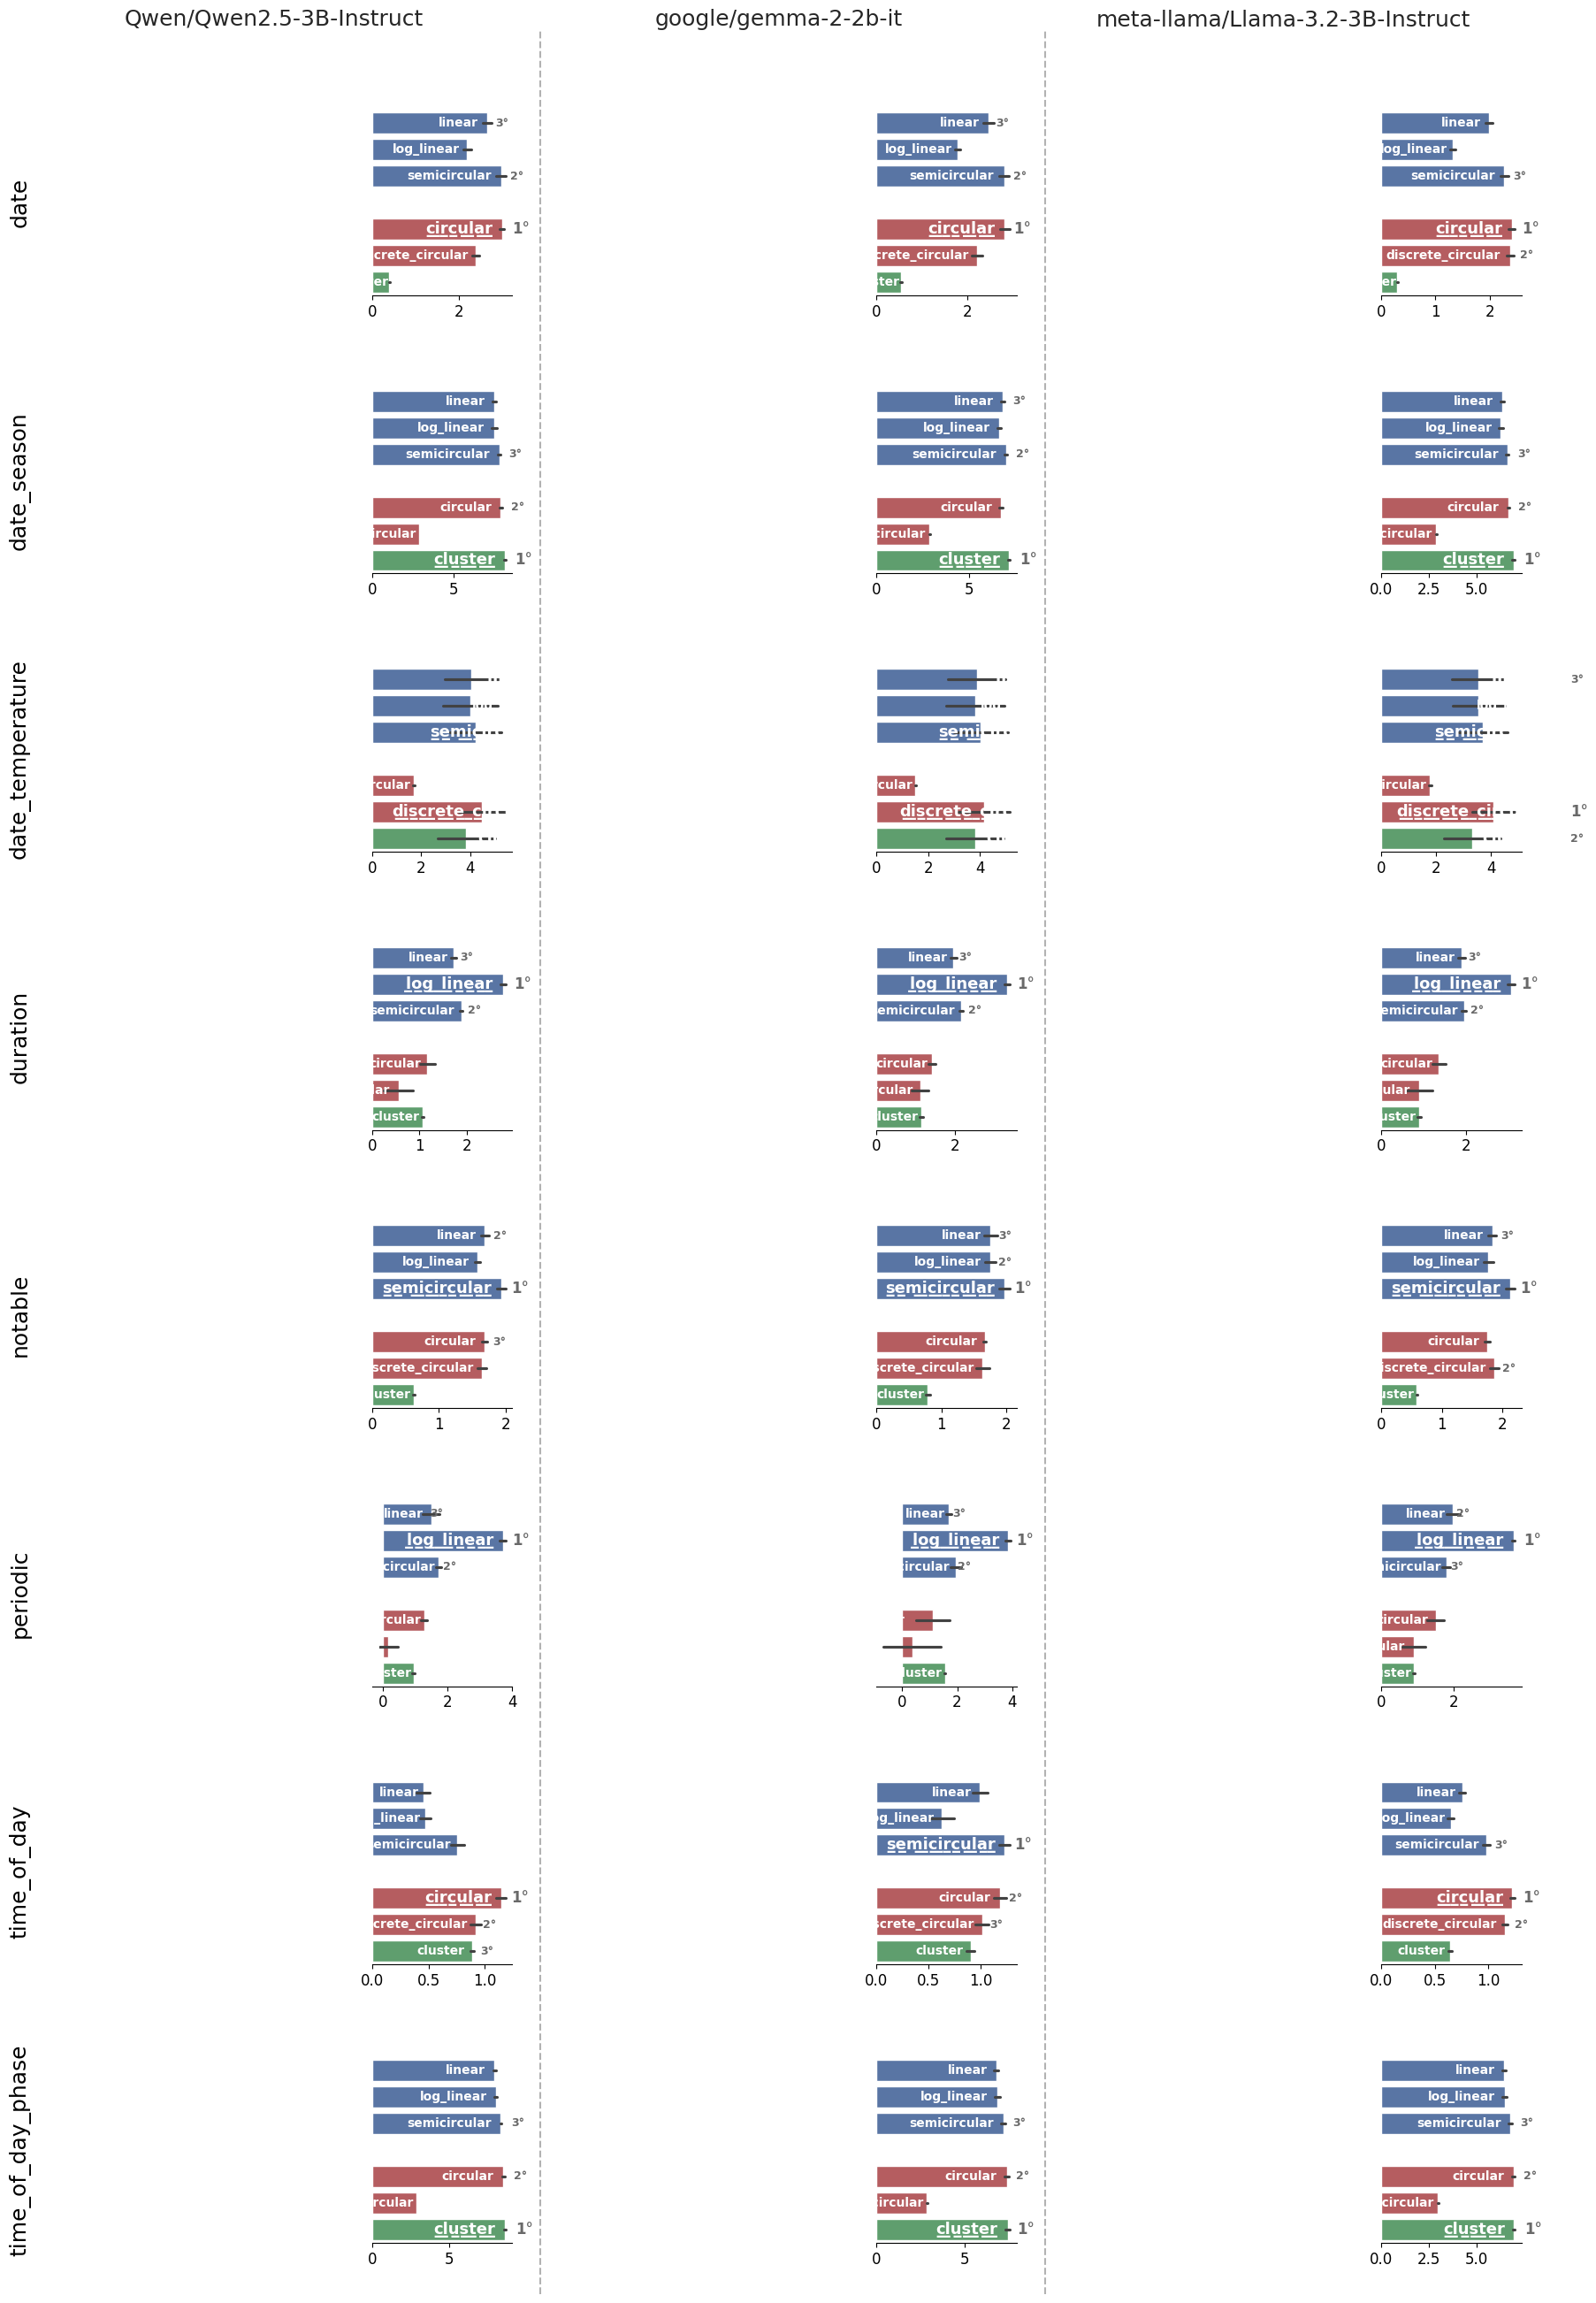

In [1]:
# Main Plot of the paper - Confidence intervals

from matplotlib import gridspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time_stuff.utils import ActivationDataset
from time_stuff.plot import  plot_activations, plot_activations_single
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D

plt.rcParams['text.usetex'] = False

# Define reordered Set1 palette from list of original colors
reordered_colors = sns.color_palette("deep", n_colors=9)
reordered_colors = [reordered_colors[3], reordered_colors[2], reordered_colors[0], ]
reordered_Set1 = sns.color_palette(reordered_colors, n_colors=len(reordered_colors))


def underline(text):
    return ''.join(char + '\u0332' for char in text)

def create_custom_subplot_grid(fig_rows, fig_cols, figsize_multiplier=(5, 4)):
    """
    Create a custom subplot grid where even columns have full width and odd columns have half width.
    """
    
    # Calculate figure size
    width_mult, height_mult = figsize_multiplier
    figsize = (fig_cols * width_mult * 2, fig_rows * height_mult)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=0.2)  # Increase left margin to fit ylabels

    
    # Create gridspec with 3 grid columns per column pair
    # This allows us to make some subplots span 2/3 (full) and others span 1/3 (half)
    total_grid_cols = fig_cols * 3
    gs = gridspec.GridSpec(fig_rows, total_grid_cols, figure=fig)
    
    # Initialize axes array
    axs = np.empty((fig_rows, fig_cols * 2), dtype=object)
    
    # Create subplots
    for row in range(fig_rows):
        for col in range(fig_cols * 2):
            if col % 2 == 0:  # Even columns (0, 2, 4, ...) - full width
                # Span 2 out of 3 grid columns
                grid_start = (col // 2) * 3
                ax = fig.add_subplot(gs[row, grid_start:grid_start + 2])
            else:  # Odd columns (1, 3, 5, ...) - half width
                # Span 1 out of 3 grid columns
                grid_start = (col // 2) * 3 + 2
                ax = fig.add_subplot(gs[row, grid_start:grid_start + 1])
            
            axs[row, col] = ax
    
    return fig, axs

def add_subplot_separators(fig, axs, direction='vertical', every_n=1, 
                            color='black', linewidth=1.5, alpha=0.3, linestyle='--',
                            margin=(0.05, 0.95)):
    """
    Adds separator lines between subplot groups without affecting layout.
    """
    
    axs = np.atleast_2d(axs)
    nrows, ncols = axs.shape

    if direction == 'vertical':
        for col in range(every_n, ncols, every_n):
            ax = axs[0, col]
            bbox = ax.get_position()
            x = bbox.x0
            line = Line2D([x, x], [margin[0], margin[1]],
                          transform=fig.transFigure,
                          color=color, linewidth=linewidth, alpha=alpha,
                          linestyle=linestyle, zorder=1000, clip_on=False)
            fig.add_artist(line)

    elif direction == 'horizontal':
        for row in range(every_n, nrows, every_n):
            ax = axs[row, 0]
            bbox = ax.get_position()
            y = bbox.y1
            line = Line2D([margin[0], margin[1]], [y, y],
                          transform=fig.transFigure,
                          color=color, linewidth=linewidth, alpha=alpha,
                          linestyle=linestyle, zorder=1000, clip_on=False)
            fig.add_artist(line)
    else:
        raise ValueError("direction must be 'vertical' or 'horizontal'")

def add_shared_title(text, ax1, ax2, fig=None, y_pad=0.02, fontsize=14, **kwargs):
    """
    Adds a shared title above two horizontally adjacent Axes.
    """
    if fig is None:
        fig = ax1.figure

    # Get positions in figure coordinates
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()

    # Calculate center and top position
    x_center = (pos1.x0 + pos2.x1) / 2
    y_top = max(pos1.y1, pos2.y1)

    # Add text to figure
    fig.text(x_center, y_top + y_pad, text,
             ha='center', va='bottom', fontsize=fontsize, **kwargs)

def clean_scatterplot(ax):
    # 1. Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])


    # 2. Remove borders (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 3. Optional: lighter background
    # ax.set_facecolor('#f9f9f9')  # subtle off-white

def clean_barplot(ax, subset, order=None):
    # 1. Clean gridless style
    sns.set_style("white")
    # 2. Remove spines (all borders)
    sns.despine(ax=ax, left=True)
   
    # 4. Move labels inside bars
    ax.set_yticklabels([])
    ax.set_ylabel('')
    
    # Use the order list to iterate in the correct sequence
    if order is not None:
        manifolds_to_process = order
    else:
        manifolds_to_process = subset['manifold'].unique()

    top_manifolds = subset.nlargest(3, 'norm_score')['manifold'].tolist()
    
    for i, manifold in enumerate(manifolds_to_process):
        # Get the value for this manifold
        value = subset[subset['manifold'] == manifold]
        value = value['norm_score'].iloc[0] if not value.empty else 0
        midpoint = subset['norm_score'].clip(lower=0).mean()
        maximum = subset['norm_score'].max() if not subset['norm_score'].empty else 0

        if value > 0:
            if value == maximum:
                ax.text(value * 0.93, i, underline(manifold), ha='right', va='center', color='white', fontsize=13, fontweight='bold')
            else:
                ax.text(value * 0.93, i, manifold, ha='right', va='center', color='white', fontsize=10, fontweight='bold')

        # Add ranking markers for top 3
        if manifold in top_manifolds:
            rank = top_manifolds.index(manifold) + 1
            marker = f"{rank}°"
            if rank == 1:
                ax.text(value * 1.08, i, marker, ha='left', va='center', 
                    color='dimgray', fontsize=12, fontweight='bold')
            elif rank != 1:
                ax.text(value * 1.08, i, marker, ha='left', va='center', 
                    color='dimgray', fontsize=9, fontweight='bold')
            
        # if value > midpoint:  # Inside the bar
        #     ax.text(value * 0.95, i, manifold, ha='right', va='center', color='white', fontsize=10, fontweight='bold')
        # elif value > 0:  # Outside the bar
        #     ax.text(value * 1.05, i, manifold, ha='left', va='center', color='dimgray', fontsize=10, fontweight='bold')
        # else:
        #     ax.text(0.05, i, manifold, ha='left', va='center', color='dimgray', fontsize=10, fontweight='bold')
    
    # # 5. Reduce x-axis elements
    # ax.set_xlabel('')
    # ax.set_xticks([])
    # ax.set_xticks([0.0, 0.3, 0.7, 1.0])
    # Set font size at 0.8
    ax.tick_params(axis='x', labelsize=12)

df = pd.read_csv('results/combined_scores.csv')
target_col = 'last_prompt_token'  # or 'last_prompt_token' based on your analysis

# Filter dataset
df = df[df['n_components'] == 3]
df = df[df['target_col'] == target_col]
df = df[df['layer'] > 2]
df = df[np.isinf(df['score']) == False]  # Remove inf scores
# df = df[df['target_col'] == 'last_prompt_token']
df = df[~df['manifold'].isin(['log_semicircular'])]

# Rename manifold trivial to cluster
df['manifold'] = df['manifold'].replace({'trivial': 'cluster'})

# df = df[df['dataset_name'].isin(['date_3way', 'date_3way_season', 'periodic_3way', 'notable_3way'])] 
# df = df[df['dataset_name'].isin(['date_3way_temperature', 'duration_3way', 'time_of_day_3way', 'time_of_day_3way_phase'])]
df = df[~((df['dataset_name'] == 'date_3way_season') & (df['preprocess_func'] == 'datetime_to_dayofyear'))]
# df = df[df['dataset_name'].isin(['date_3way', 'date_3way_season'])] # Plot 1
# df = df[df['dataset_name'].isin(['periodic_3way', 'notable_3way'])] # Plot 2

### DEBUG ### 
# df = df[df['dataset_name'].isin(['date_3way',])]
# df = df[df['model_name'].isin(['meta-llama/Llama-3.2-3B-Instruct'])]


# Step 1: For each (model, dataset), get the best (layer, score)
best_layer_manifold = df.loc[df.groupby(['model_name', 'dataset_name'])['score'].idxmax()][['model_name', 'dataset_name', 'layer']]
best_layer_manifold = best_layer_manifold.rename(columns={'layer': 'best_layer'})

# Step 2: Get all the scores for all manifolds but only for the best layer
all_scores = df.merge(best_layer_manifold, on=['model_name', 'dataset_name'])

# Step 2.5: all_scores['fold_scores'] contains a list. Explode it to get individual scores
# First convert the string column into a column of lists
all_scores['fold_score'] = all_scores['fold_scores'].apply(lambda x: eval(x) if isinstance(x, str) else x)
all_scores = all_scores.drop(columns=['fold_scores'])
all_scores = all_scores.explode('fold_score')
all_scores['fold_score'] = all_scores['fold_score'].astype(float)  # Ensure fold_score is float

best_scores = all_scores[all_scores['layer'] == all_scores['best_layer']]



# Step 3: Compute the relative score wrt the best manifold for each (model, dataset)
best_scores['norm_score'] = best_scores.groupby(['model_name', 'dataset_name'])['score'].transform(
    # lambda x: (x - x.min()) / (x.max() - x.min() if x.max() != x.min() else 1)
    # lambda x: x
    # lambda x: (x-x.mean()) / (x.std() if x.std() != 0 else 1)  # Normalize to mean and std
    # lambda x: (x.clip(lower=0) - x.clip(lower=0).min()) / (x.max() - x.clip(lower=0).min() if x.max() != x.clip(lower=0).min() else 
    lambda x: -np.log(1-x)
)
# best_scores['norm_score'] = best_scores.transform(lambda x: -np.log(1-x['score']))
best_scores['norm_fold_score'] = best_scores.groupby(['model_name', 'dataset_name'])['fold_score'].transform(lambda x: -np.log(1-x))


best_scores['manifold_type'] = best_scores['manifold'].map({
    'euclidean': 'linear', 
    'discrete_circular': 'circular', 
    'cluster': 'cluster',
    'circular': 'circular',
    'semicircular': 'linear',
    'log_linear': 'linear',
    'log_semicircular': 'linear'})

# Rename euclidean to linear
best_scores['manifold'] = best_scores['manifold'].replace({'euclidean': 'linear'})

# Step 4: Get the best manifold
best_manifolds = best_scores.loc[best_scores.groupby(['model_name', 'dataset_name'])['norm_score'].idxmax()]
    
best_scores['label_col'] = best_scores['dataset_name'].map({
    'duration_3way': 'correct_duration_length',
    'date_3way': 'correct_date',
    'time_of_day_3way': 'correct_time',
    'notable_3way': 'correct_date',
    'periodic_3way': 'correct_period_length',
})

# best_scores = best_scores[best_scores['model_name'] == 'meta-llama/Llama-3.2-3B-Instruct']
# best_scores = best_scores[best_scores['dataset_name'] == 'date_3way']
best_scores = best_scores[(best_scores['dataset_name'] != 'duration_3way') | (best_scores['preprocess_func'].isna())]
# print(best_scores[['model_name', 'dataset_name', 'manifold', 'score', 'layer']].to_string(index=False))



#### MANIFOLD PLOTS ####
best_manifolds['preprocess_func'] = best_manifolds['dataset_name'].map({
    'duration_3way': None,
    'date_3way': lambda x: pd.to_datetime(x).day_of_year,
    'time_of_day_3way': lambda x: pd.to_datetime(x).hour,
    'notable_3way': lambda x: pd.to_datetime(x).year,
    'periodic_3way': None,
})
best_manifolds['postprocess_func'] = best_manifolds['dataset_name'].map({
    'periodic_3way': lambda x: np.log(x + 1),
    'duration_3way': lambda x: np.log(x + 1),
})
# best_manifolds['category_hue'] = best_manifolds['manifold_type'].map({
#     t:h for t, h in zip(['linear', 'circular', 'cluster'], sns.color_palette(n_colors=3))
#     })
    

def plot_activation_manifold(model_name, dataset_name, layer, manifold, manifold_type, ax, target_col, 
                             label_col=None, preprocess_func=None, postprocess_func=None):
    # Load the activation dataset
    model_name = model_name.split('/')[-1]  # Extract the model name from the full path
    ad_path = f'results/{model_name}/{dataset_name}.pt'
    ad = ActivationDataset.load(ad_path)
    # TODO: define other palette
    if manifold_type == 'circular':
        palette = 'twilight'
    elif manifold_type == 'linear':
        palette = 'flare'
    else:
        palette = 'tab10'
    plot_activations_single(
        ad, 
        label_col=label_col,
        target_col=target_col,
        reduction_method='SMDS',
        layer=layer,
        ax=ax,
        manifold=manifold,
        palette=palette,
        preprocess_func=preprocess_func,
        postprocess_func=postprocess_func,
    )

best_manifolds = best_manifolds.sort_values(by=['dataset_name', 'model_name', 'manifold_type', 'norm_score'], ascending=[True, True, True, False])
best_scores = best_scores.sort_values(by=['dataset_name', 'model_name', 'manifold_type', 'norm_score'], ascending=[True, True, True, False])
# print(best_manifolds.to_string(index=False))
#DEBUG
# best_manifolds = best_manifolds[:9]

fig_rows = best_manifolds['dataset_name'].nunique()
fig_cols = best_manifolds['model_name'].nunique()
# fig, axs = plt.subplots(
#     nrows=fig_rows, 
#     ncols=fig_cols * 2, 
#     figsize=(fig_cols * 5 * 2, fig_rows * 4), 
#     # constrained_layout=Truee
# )
fig, axs = create_custom_subplot_grid(fig_rows, fig_cols, figsize_multiplier=(4, 4))

add_subplot_separators(fig, axs, direction='vertical', every_n=2, margin=(0.1, 0.9))
# add_subplot_separators(fig, axs, direction='horizontal', every_n=1)

# Plot histogram of scores for each dataset
order = ['linear', 'log_linear', 'semicircular', 'log_semicircular', 'circular', 'discrete_circular', 'cluster']

for i, (index, row) in enumerate(best_manifolds.drop(columns=['norm_fold_score', 'fold_score']).drop_duplicates().iterrows()):
    ax_r = i // fig_cols
    ax_c = (i*2+1) % (fig_cols * 2)
    # plt.figure(figsize=(10, 6))
    ax = axs[ax_r][ax_c]  # Use the second column for the bar plot
    subset = best_scores[best_scores['dataset_name'] == row['dataset_name']]
    subset = subset[subset['model_name'] == row['model_name']]
    
    clean_barplot(ax, subset.drop(columns=['norm_fold_score', 'fold_score']).drop_duplicates(), order=order)

    sns.barplot(
        data=subset, 
        x='norm_fold_score', 
        y='manifold', 
        hue='manifold_type',
        errorbar='se',
        order=order,
        palette=reordered_Set1,
        ax=ax,  
    )

    ax.set(xlabel=None)

    # if ax_r == 0 and ax_c == fig_cols*2 - 1:
    #     # First get the existing legend handles and labels
    #     handles, labels = ax.get_legend_handles_labels()

    #     # Desired order
    #     desired_order = ['linear', 'circular', 'cluster']

    #     # Reorder handles and labels according to desired order
    #     sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: desired_order.index(hl[1]))
    #     handles, labels = zip(*sorted_handles_labels)

    #     # Now pass the reordered handles and labels to legend
    #     ax.legend(
    #         handles, labels,
    #         loc='upper right', 
    #         bbox_to_anchor=(2.2, 1), 
    #         title='Manifold Topology',
    #         fontsize=12,
    #         title_fontsize=14,
    #     )

    # else:
    ax.get_legend().set_visible(False)

    # Rescale the y-axis to 0.8 original
    pos = ax.get_position()  # Bbox(x0, y0, x1, y1)
    new_height = pos.height * 0.8
    y_offset = (pos.height - new_height) / 2

    # Set the new position: (x0, y0 + offset, width, new_height)
    ax.set_position([pos.x0, pos.y0 + y_offset, pos.width, new_height])
    ax.tick_params(axis='y', pad=-10, colors='white')
    ax.set_ylabel('')
    # Set alignment and styling for y-tick labels
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')
        label.set_fontweight('bold')
        label.set_color('white')
        # Add white outline
        # label.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
        #                     path_effects.Normal()])

for i, (index, row) in enumerate(best_manifolds.drop(columns=['norm_fold_score', 'fold_score']).drop_duplicates().iterrows()):
    ax_r = i // fig_cols
    ax_c = (i*2) % (fig_cols * 2)
    model_name = row['model_name']
    dataset_name = row['dataset_name']
    layer = row['best_layer']
    manifold = row['manifold']
    manifold_type = row['manifold_type']
    preprocess_func = row['preprocess_func'] if pd.notna(row['preprocess_func']) else None
    label_col = row.get('label_col', None) if pd.notna(row['label_col']) else None  # Use .get() to avoid KeyError if 'label_col' is not present
    postprocess_func = row.get('postprocess_func', None) if pd.notna(row['postprocess_func']) else None  # Use .get() to avoid KeyError if 'postprocess_func' is not present
    clean_scatterplot(axs[ax_r][ax_c])

    print(f"Plotting {model_name} - {dataset_name} - {layer} - {manifold}")
    # plot_activation_manifold(model_name, dataset_name, layer, manifold, manifold_type, axs[ax_r][ax_c], target_col=target_col,
    #                          label_col=label_col, preprocess_func=preprocess_func, postprocess_func=postprocess_func)
    if ax_r == 0:
        # axs[ax_r][ax_c].set_title(model_name, fontsize=14)
        add_shared_title(model_name, axs[ax_r][ax_c], axs[ax_r][ax_c + 1], fig=fig, y_pad=0.02, fontsize=18)
    if ax_c == 0:
        axs[ax_r][ax_c].set_ylabel(dataset_name.replace('_3way',''), fontsize=18)
    # plt.tight_layout()

# fig.show()
fig.savefig('plots/manifolds_debug.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Best model - task - accuracy pairs
import pandas as pd
import numpy as np


df = pd.read_csv('results/scores/all_scores.csv')

# Filter dataset
df = df[df['n_components'] > 2]
# df = df[df['target_col'] == 'correct_answer']

df.groupby(['model_name', 'dataset_name'])['accuracy'].max().reset_index().sort_values(by=['accuracy'], ascending=False).head(100)

,model_name,dataset_name,accuracy
0,meta-llama/Llama-3.1-70B-Instruct,date_3way,0.929719
1,meta-llama/Llama-3.1-70B-Instruct,date_3way_season,0.834500
2,meta-llama/Llama-3.1-70B-Instruct,date_3way_temperature,0.821000
16,meta-llama/Llama-3.2-3B-Instruct,date_3way,0.808735
17,meta-llama/Llama-3.2-3B-Instruct,date_3way_season,0.737000
7,meta-llama/Llama-3.1-70B-Instruct,time_of_day_3way_phase,0.729000
15,meta-llama/Llama-3.1-8B-Instruct,time_of_day_3way_phase,0.689000
23,meta-llama/Llama-3.2-3B-Instruct,time_of_day_3way_phase,0.662500
9,meta-llama/Llama-3.1-8B-Instruct,date_3way_season,0.661500
3,meta-llama/Llama-3.1-70B-Instruct,duration_3way,0.618000


### Intervention

In [30]:
# Plot of intervention accuracies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time_stuff.utils import ActivationDataset
import os

# dir_path = 'results/intervention_replace/Llama-3.2-3B-Instruct/date_3way'
# dir_path = 'results/intervention_replace/Llama-3.2-3B-Instruct'
# dir_path = 'results/intervention_rand/Llama-3.2-3B-Instruct'
dir_path = 'results/intervention_full/Llama-3.2-3B-Instruct'

metadata = []
# Loop through all files in the folder and subfolder recursively
for root, dirs, files in os.walk(dir_path):
    for file in files:
        if not file.endswith('.pt'):
            continue
        # Load the activation dataset
        try:
            # Load the activation dataset
            ad = ActivationDataset.load(os.path.join(root, file))
            metadata.append(ad.global_metadata)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue

# Create a DataFrame from the metadata
df = pd.DataFrame(metadata)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
df.to_csv(f'{dir_path}/intervention_metadata.csv', index=False)

/tmp/ipykernel_102517/2990972382.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['intervention_type'][df['intervention_type'].isna()] = 'SMDS'
/tmp/ipykernel_102517/2990972382.py:33: SettingWithCopyWarning: 
A value is trying to be s

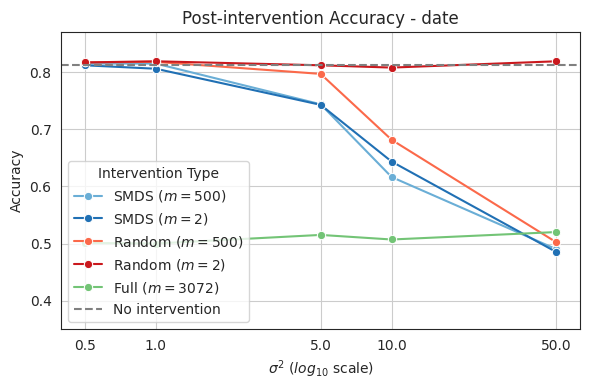

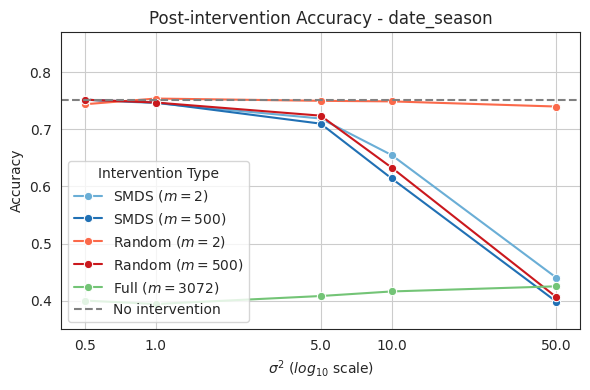

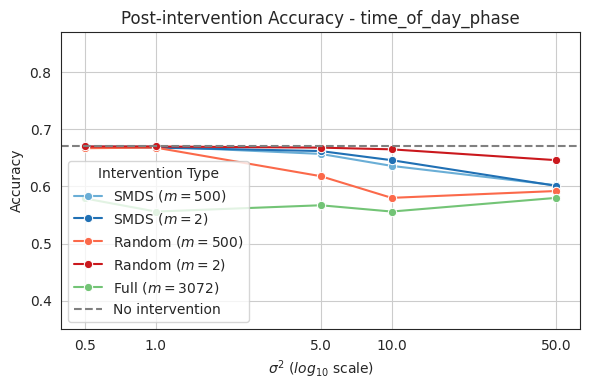

In [ ]:
from matplotlib import ticker
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def row2label(x):
    it_map = {
        'replace': 'SMDS',
        'SMDS': 'SMDS',
        'rand': 'Random',
        'full': 'Full',
    }
    intervention_type = it_map[x['intervention_type']]
    n_components = x['n_components'] if intervention_type != 'Full' else 3072
    return f"{intervention_type} ($m = {n_components}$)"

# dir_paths = ['results/intervention_full/Llama-3.2-3B-Instruct/date_3way',
#              'results/intervention_rand/Llama-3.2-3B-Instruct/date_3way',
#              'results/intervention_replace/Llama-3.2-3B-Instruct/date_3way']

dir_paths = ['results/intervention_full/Llama-3.2-3B-Instruct',
             'results/intervention_rand/Llama-3.2-3B-Instruct',
             'results/intervention_replace/Llama-3.2-3B-Instruct']

dfs = []
for dir_path in dir_paths:
    df = pd.read_csv(f'{dir_path}/intervention_metadata.csv')
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

df['dataset_name'] = df['dataset_name'].map(lambda x: x.replace('_3way', ''))
df['intervention_type'][df['intervention_type'].isna()] = 'SMDS'

# Select a few important intervention cases
# - n doesn't matter for replace, take 2 and 100
# - rand is a baseline, take the same as replace
# - take all values for full
    

for task in df['dataset_name'].unique():
    df_task = df[df['dataset_name'] == task]

    baseline_accuracy = df_task[df_task['noise_scale'] == 0.0]['accuracy'].mean() # All the same
    df_task = df_task[df_task['noise_scale'] > 0.0]  # Filter out noise_scale = 0.0

    # Plot a line plot of accuracy over noise_scale
    # df_task['log_n_components'] = np.round(np.log10(df_task['n_components']), 3)
    # log_to_label = {
    #     np.round(np.log10(val), 3): str(val) for val in sorted(df_task['n_components'].unique())
    # }
    df_task['label'] = df_task.apply(row2label, axis=1)


    df_replace = df_task[df_task['intervention_type'] == 'SMDS']
    df_replace = df_replace[df_replace['n_components'].isin([500, 2])]

    df_rand = df_task[df_task['intervention_type'] == 'rand']
    df_rand = df_rand[df_rand['n_components'].isin([500, 2])]
    df_full = df_task[df_task['intervention_type'] == 'full']
    df_task = pd.concat([df_replace, df_rand, df_full], ignore_index=True)
    # palette = sns.color_palette("viridis", as_cmap=False, n_colors=df_task['label'].nunique())
    # Generate color groups
    group1 = sns.color_palette("Blues", 3)[1:3]      # Two similar blues
    group2 = sns.color_palette("Reds", 3)[1:3]       # Two similar reds
    distinct = [sns.color_palette("Greens", 5)[2]]   # One distinct green
    # group1.reverse()
    # group2.reverse()
    custom_palette = group1 + group2 + distinct


    plt.figure(figsize=(6, 4))
    # Change group order
    df_task['label'] = pd.Categorical(df_task['label'],
                                        categories=['SMDS ($m = 2$)', 'SMDS ($m = 500$)',
                                                    'Random ($m = 2$)', 'Random ($m = 500$)',
                                                    'Full ($m = 3072$)'],
                                        ordered=True)
    df_task = df_task.sort_values(by='label')
    ax = sns.lineplot(
        data=df_task,
        x='noise_scale',
        y='accuracy',
        hue='label',
        marker='o',
        palette=custom_palette,
    )
    # sns.lineplot(
    #     data=df_rand,
    #     x='noise_scale',
    #     y='accuracy',
    #     hue='label',
    #     marker='o',
    #     # palette='magma',
    #     ax=ax,  # Use the same axis
    # )
    # sns.lineplot(
    #     data=df_full,
    #     x='noise_scale',
    #     y='accuracy',
    #     hue='label',
    #     marker='o',
    #     ax=ax,  # Use the same axis
    # )

    # Log scale
    ax.set_xscale('log')
    ax.set_xticks(df_task['noise_scale'].unique())
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    # Add baseline line
    ax.axhline(baseline_accuracy, linestyle='--', color='grey', label='No intervention')

    # Fix legend
    # handles, labels = ax.get_legend_handles_labels()
    # mapped_labels = []
    # for label in labels:
    #     if label == '0 (No intervention)':
    #         mapped_labels.append('0 (No intervention)')
    #     else:
    #         mapped_labels.append(log_to_label[float(label)])
    # if ax.legend_ is not None:
    #     # Remove the existing legend
    #     ax.legend_.remove()
    # ax.legend(handles=handles, labels=mapped_labels, title='Subspace dimension')

    # Labels and layout
    ax.legend(title='Intervention Type')
    plt.title(f'Post-intervention Accuracy - {task.replace("_3way", "")}')
    plt.xlabel('$\\sigma^2$ ($log_{10}$ scale)')
    plt.ylabel('Accuracy')
    plt.ylim(0.35, 0.87)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/intervention_accuracy_{task}.pdf', bbox_inches='tight', dpi=300)
    plt.show()        


/home/tiblias/Projects/time-stuff/time_stuff/utils.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df[col] = metadata_df[col].apply(func)
/home/tiblias/Projects/time-stuff/time_stuff/utils.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df[col] = metadata_df[col].apply(func)
3it [00:06,  2.05s/it]


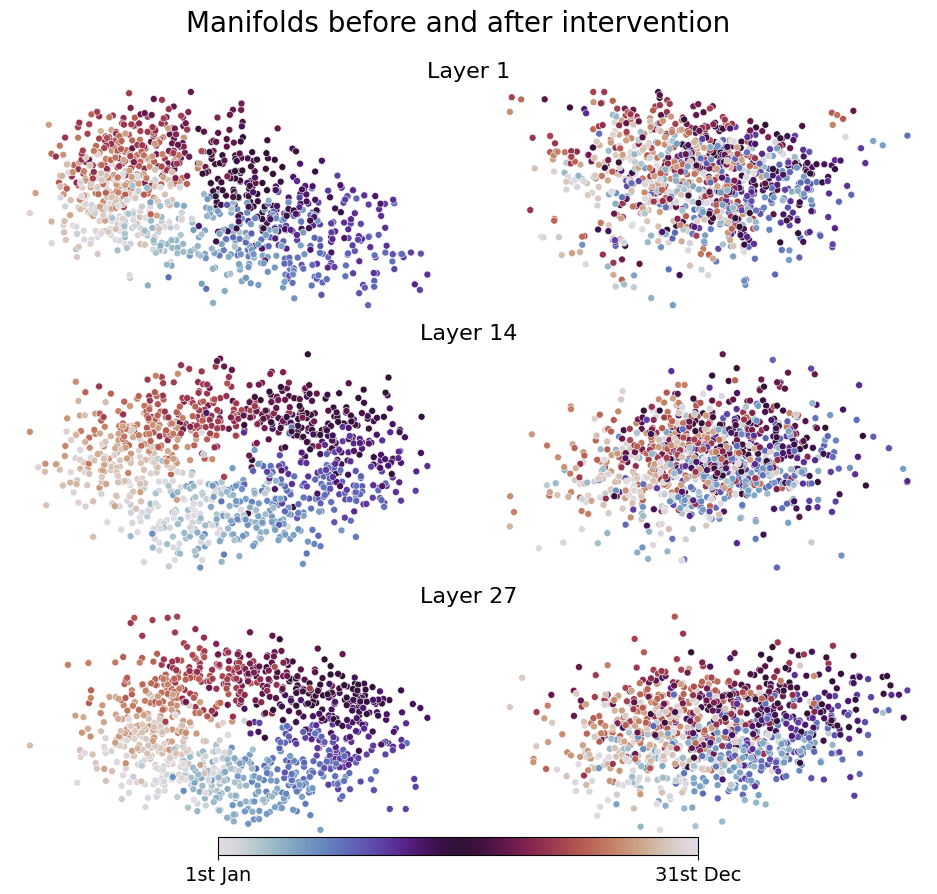

In [2]:
# Compare two sets of embeddings before and after the intervention
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_stuff.utils import SupervisedMDS
from time_stuff.utils import ActivationDataset
from mpl_toolkits.axes_grid1 import make_axes_locatable

def datetime_to_dayofyear(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the day of the year
    return x.day_of_year

def add_shared_title(text, ax1, ax2, fig=None, y_pad=0.02, fontsize=14, **kwargs):
    """
    Adds a shared title above two horizontally adjacent Axes.
    """
    if fig is None:
        fig = ax1.figure

    # Get positions in figure coordinates
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()

    # Calculate center and top position
    x_center = (pos1.x0 + pos2.x1) / 2
    y_top = max(pos1.y1, pos2.y1)

    # Add text to figure
    fig.text(x_center, y_top + y_pad, text,
             ha='center', va='bottom', fontsize=fontsize, **kwargs)
    
def clean_scatterplot(ax):
    # 1. Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])


    # 2. Remove borders (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

def train_smds(activations_train, labels_train,
                     n_components=2, manifold='discrete_circular',
                     ):
    
    rmodel = SupervisedMDS(n_components=n_components, manifold=manifold)

    rmodel.fit(activations_train, labels_train)

    if labels_train.ndim > 1:
        raise NotImplementedError("Multi-dimensional labels not supported in this version.")

    return rmodel


def add_continuous_legend(fig, palette, min_text, max_text, min_val=0, max_val=1, label=None,
                             left=0.25, bottom=0.08, width=0.5, height=0.025):
    """
    Adds a horizontal colorbar aligned across the whole figure.
    
    Parameters:
    - fig: The matplotlib Figure.
    - palette: Colormap name or object.
    - min_text, max_text: Labels for ends of the colorbar.
    - min_val, max_val: Numerical range of the color scale.
    - label: Optional label centered under the colorbar.
    - left, bottom, width, height: Position in figure coordinates.
    """
    cmap = plt.get_cmap(palette) if isinstance(palette, str) else palette
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cbar_ax = fig.add_axes([left, bottom, width, height])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    cbar.set_ticks([min_val, max_val])
    cbar.set_ticklabels([min_text, max_text])
    if label:
        cbar.set_label(label, fontsize=12, labelpad=8)

    cbar.ax.tick_params(labelsize=14)
    return cbar


title = 'Manifolds before and after intervention'
target_column = 'last_prompt_token'
label_column = 'correct_date'
preprocess_func = datetime_to_dayofyear
plots_per_row = 2
components = (0, 1)
label_col_str = 'correct_date'
annotations = 'centroids'
annotation_preprocess_func = lambda x: pd.to_datetime(x).strftime('%B')

ad_og = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')
ad_int = ActivationDataset.load('results/intervention_replace/Llama-3.2-3B-Instruct/date_3way/date_3way_n2_s50.pt')

layers = [int(np.clip(ad_int.n_layers * p, a_min=1, a_max=ad_int.n_layers-1)) for p in np.linspace(0, 1, 3)]
n_components = ad_int.global_metadata['n_components']
manifold = ad_int.global_metadata['smds'].manifold

# Retrieve dataset from existing activation dataset
df_og = ad_og.get_metadata_df().copy()
df_int = ad_int.get_metadata_df().copy()

# Do a train-test split of activations, labels and dataset
activations_og, labels_og = ad_og.get_slice(target_name=target_column, columns=label_column, preprocess_funcs=preprocess_func, filter_incorrect=False)
activations_int, labels_int = ad_int.get_slice(target_name=target_column, columns=label_column, preprocess_funcs=preprocess_func, filter_incorrect=False)

activations_train = activations_og[:int(len(activations_og) * 0.5)]
activations_test_og = activations_og[int(len(activations_og) * 0.5):]
activations_test_int = activations_int
labels_train = labels_og[:int(len(labels_og) * 0.5)]
labels_test = labels_int
if not np.all(labels_og[int(len(labels_og) * 0.5):] == labels_test):
    raise ValueError("Labels of the test set do not match the labels of the intervention dataset.")

df_train = df_og[:int(len(df_og) * 0.5)]
df_test = df_int

# df_test = df_test.sample(n=15)

# Plot the data
scaling_factor = 6 if len(layers) > 1 else 6
plots_per_row = 2 # Fixed for plots
fig, axs = plt.subplots(len(layers), plots_per_row, 
                        figsize=(scaling_factor*plots_per_row*0.8, 
                                 scaling_factor*len(layers)//plots_per_row))
fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad=0)
plt.subplots_adjust(top=0.9)


for i, layer in tqdm(enumerate(layers)):
    activations_layer_train = activations_train[:, layer]
    activations_layer_dev_og = activations_test_og[:, layer]
    activations_layer_dev_int = activations_test_int[:, layer]

    # Fit the model
    rmodel = train_smds(
        activations_layer_train,
        labels_train,
        n_components=n_components,
        manifold=manifold,
    )
    # Transform the data
    activations_reduced_dev_og = rmodel.transform(activations_layer_dev_og)
    activations_reduced_dev_int = rmodel.transform(activations_layer_dev_int)

    hues = labels_test
    # Plot the data
    palette = 'twilight' if len(np.unique(hues)) > 2 else ['#3A4CC0', '#B40426']#['blue', 'red']

    if len(components) == 2:
        sns.scatterplot(x=activations_reduced_dev_og[:, components[0]], y=activations_reduced_dev_og[:, components[1]], 
                        hue=hues, ax=axs[i][0], palette=palette, alpha=1.0, s=25) 
        sns.scatterplot(x=activations_reduced_dev_int[:, components[0]], y=activations_reduced_dev_int[:, components[1]], 
                        hue=hues, ax=axs[i][1], palette=palette, alpha=1.0, s=25) 
        
    # elif len(components) == 3:
    #     ax.scatter(activations_reduced_dev[:, components[0]], activations_reduced_dev[:, components[1]],
    #                 activations_reduced_dev[:, components[2]], c=hues, s=20, cmap=palette)
    axs[i][0].get_legend().set_visible(False)
    axs[i][1].get_legend().set_visible(False)
    # Set title
    # TODO: set combined title
    # axs[i][0].set_title("Bla bla")
    # axs[i][1].set_title("Bla bla")
    clean_scatterplot(axs[i][0])
    clean_scatterplot(axs[i][1])
    add_shared_title(f"Layer {layer}", axs[i][0], axs[i][1], fig=fig, y_pad=0, fontsize=16)
    # if i == 2:
    #     add_continuous_legend(
    #         fig = fig,
    #         # [axs[i][0], axs[i][1]],
    #         palette = palette,
    #         min_text="31st Dec",
    #         max_text="1st Jan",
    #         left=1, bottom=0.25, width=0.02, height=0.5,)

# Add colorbar to the right of the last plot on the third row
add_continuous_legend(
    fig=fig,
    palette=palette,
    min_text="1st Jan",
    max_text="31st Dec",
    min_val=np.min(labels_test),
    max_val=np.max(labels_test),
    left=0.25, bottom=0.04, width=0.5, height=0.02  # adjust spacing if needed
)


# Set the title
fig.suptitle(title, fontsize=20)
plt.savefig('plots/intervention_latents.pdf', dpi=300)
plt.show()
plt.close(fig)


In [ ]:
# Print noisy generated text from the intervention dataset

from time_stuff.utils import ActivationDataset
import os
import pandas as pd


ad = ActivationDataset.load('results/intervention_rand/Llama-3.2-3B-Instruct/date_3way/date_3way_n100_s50.pt')
print(ad.get_accuracy())
pd.set_option('display.max_colwidth', 500)
df = ad.get_metadata_df()
# Concat decoded and sentence columns
df['decoded'] = df['decoded'].fillna('')
df['sentence'] = df['sentence'].fillna('')
df['text'] = df['correct'].astype(str) + ' ' + df['decoded']
# Print the first few rows of the DataFrame

# Print all the characters in the 'text' column

print(df['text'].head(10).to_string(index=False))


0.44879518072289154
  False Jerry renovated the bathroom on the 10th of August. Henry renovated the bathroom on the 31st of July. John renovated the bathroom on the 23rd of August. The first person that renovated the bathroom was Jerry. Jerry renovated the bathroom on the
                                       False Kevin donated toys on the 29th of August. Michael donated toys on the 22nd of July. Richard donated toys on the 20th of August. The first person that donated toys was Kevin. The last person that donated toys
                                         True Frank won the lottery on the 3rd of May. Charlie won the lottery on the 1st of May. Kyle won the lottery on the 18th of May. The first person that won the lottery was Charlie. Charlie won the lottery on the
                           False Maria visited a new city on the 25th of March. Andrew visited a new city on the 16th of February. Max visited a new city on the 21st of March. The first person that visited a new city was 

In [ ]:
import pandas as pd


pd.set_option('display.max_colwidth', 1000)
df = ad.get_metadata_df()
# Concat decoded and sentence columns
df['decoded'] = df['decoded'].fillna('')
df['sentence'] = df['sentence'].fillna('')
df['text'] = df['correct'].astype(str) + df['decoded']  
# Print the first few rows of the DataFrame

# Print all the characters in the 'text' column

print(df['text'].head(10).to_string(index=False))

  FalseJerry renovated the bathroom on the 10th of August. Henry renovated the bathroom on the 31st of July. John renovated the bathroom on the 23rd of August. The first person that renovated the bathroom was Jerry. Jerry renovated the bathroom on the
                                     FalseKevin donated toys on the 29th of August. Michael donated toys on the 22nd of July. Richard donated toys on the 20th of August. The first person that donated toys was Kevin. The second person that donated toys
                                            FalseFrank won the lottery on the 3rd of May. Charlie won the lottery on the 1st of May. Kyle won the lottery on the 18th of May. The first person that won the lottery was Frank. Frank won the lottery on the
                          FalseMaria visited a new city on the 25th of March. Andrew visited a new city on the 16th of February. Max visited a new city on the 21st of March. The first person that visited a new city was Max. The first person to 

### 2D manifold

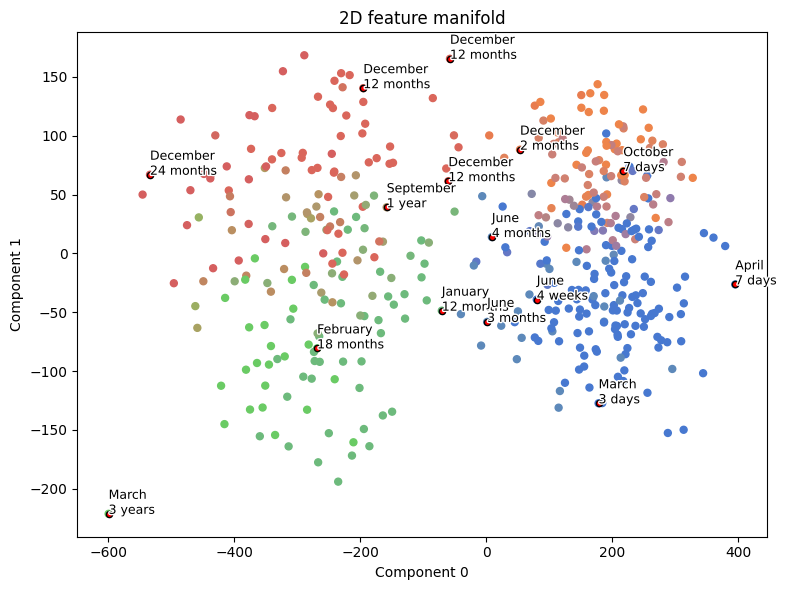

In [2]:
# Use plot_activations_single to plot the 2D duration manifold
from time_stuff.plot import plot_activations_single
import matplotlib.pyplot as plt
from time_stuff.utils import ActivationDataset
import numpy as np
import pandas as pd


def datetime_to_dayofyear(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the day of the year
    return x.day_of_year

def log_lin_ppf(labels):
    # Compute log on first column and nothing on the second
    labels = np.array(labels)
    if labels.ndim == 1:
        return np.log(labels + 1)
    elif labels.ndim == 2:
        labels[:, 0] = np.log(labels[:, 0] + 1)
        return labels

ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/duration_3way.pt')

# Make a single figure plot without subplots
fig, ax = plt.subplots(figsize=(8, 6))

# plot_activations(ad, label_col=['correct_duration_length', 'correct_date'], target_col='last_prompt_token', layers=layers, reduction_method='SMDS', plots_per_row=3,
#                  label_col_str=['correct_month', 'correct_duration_str'], preprocess_func=[lambda x: x, datetime_to_dayofyear], postprocess_func=log_lin_ppf,
#                  manifold='euclidean', 
#                  annotations='uniform', annotation_preprocess_func=lambda x: x[0] + '\n' + x[1], n_components=3)

plot_activations_single(
    ad, 
    label_col=['correct_duration_length', 'correct_date'],
    target_col='last_prompt_token',
    label_col_str=['correct_month', 'correct_duration_str'],
    reduction_method='SMDS',
    layer=7,
    ax=ax,
    manifold='euclidean',
    palette='flare',
    preprocess_func=[lambda x: x, datetime_to_dayofyear],
    postprocess_func=log_lin_ppf,
    annotations='uniform',
    annotation_preprocess_func=lambda x: x[0] + '\n' + x[1], 
    annotation_center_bias=0.07,
    n_components=3,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,  # Limit the number of samples to 1000 for performance
)
ax.grid(False)

# Display
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('2D feature manifold')
plt.tight_layout()
plt.savefig('plots/duration_manifold.pdf', bbox_inches='tight', dpi=300)
plt.show()


### Structure over depth

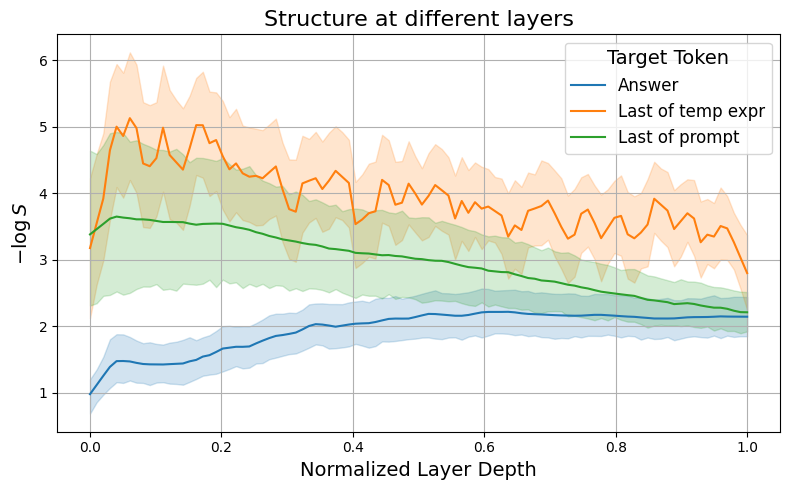

In [6]:
# Layer - structure correlation table & plot

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df = pd.read_csv('results/scores/all_scores.csv')

# Filter dataset
df = df[df['n_components'] > 2]
# df = df[df['model_name'] == 'meta-llama/Llama-3.2-3B-Instruct']
# df = df[df['dataset_name'] == 'date_3way']
# df = df[df['target_col'] == 'correct_answer'] Ignore this
# ['correct_answer' 'last_prompt_token' 'correct_duration_str'
#  'correct_date_expr' 'correct_date_str' 'correct_time_expr'
#  'correct_period_str']
df['target_col'] = df['target_col'].map({
    'correct_answer': 'correct_answer',
    'last_prompt_token': 'last_prompt_token',
    'correct_time_expr': 'correct_time_expr',
    'correct_duration_str': 'correct_time_expr',
    'correct_date_expr': 'correct_time_expr',
    'correct_date_str': 'correct_time_expr',
    'correct_period_str': 'correct_time_expr',
})

df = df[(df['dataset_name'] != 'duration_3way') | (df['preprocess_func'].isna())]  # Exclude duration_3way dataset if preprocess_func is NaN
df = df[~df['dataset_name'].isin(['date_3way_temperature'])] # Stress computation breaks down for binary datasets - an indicator of structure in itself

# Step 1: Get all the rows that use the best manifold for each (model, dataset)
best_manifold = df.loc[df.groupby(['model_name', 'dataset_name', 'target_col'])['score'].idxmax()]
df = df.merge(best_manifold[['model_name', 'dataset_name', 'target_col', 'manifold']], on=['model_name', 'dataset_name', 'target_col'], suffixes=('', '_best'))
df = df[df['manifold'] == df['manifold_best']]

# Compute the depth of each layer relative to the maximum layer for each model
df['depth'] = df.groupby('model_name')['layer'].transform(lambda x: (x-x.min()) / (x.max() - x.min() if x.max() != x.min() else 1))
df['score'] = -np.log(1 - df['score'])

# Interpolation step: define uniform depth grid
depth_grid = np.linspace(0, 1, 100)
rows = []

for (model, dataset, target), group in df.groupby(['model_name', 'dataset_name', 'target_col']):
    if len(group['depth'].unique()) < 2:
        continue  # Cannot interpolate single point
    # Sort by depth
    group_sorted = group.sort_values('depth')
    f = interp1d(
        group_sorted['depth'],
        group_sorted['score'],
        kind='linear',
        bounds_error=False,
        fill_value=(group_sorted['score'].iloc[0], group_sorted['score'].iloc[-1])
    )

    interpolated_scores = f(depth_grid)

    for d, s in zip(depth_grid, interpolated_scores):
        rows.append({
            'model_name': model,
            'dataset_name': dataset,
            'target_col': target,
            'depth': d,
            'score': s
        })

df_interp = pd.DataFrame(rows)
# print(df_interp[df_interp['depth'] < 0.1].to_string(index=False))

# Rename target_col to Target Token
df_interp['Target Token'] = df_interp['target_col'].map({
    'correct_answer': 'Answer',
    'last_prompt_token': 'Last of prompt',
    'correct_time_expr': 'Last of temp expr',
})

# Plot using interpolated data
plt.figure(figsize=(8, 5))
# sns.set_style("whitegrid")
sns.lineplot(
    data=df_interp, 
    x='depth', 
    y='score', 
    hue='Target Token', 
)
# Change legend fontsize
plt.legend(title='Target Token', fontsize=12, title_fontsize=14, loc='upper right',)
# sns.despine(top=True, right=True)
plt.title("Structure at different layers", fontsize=16)
plt.xlabel("Normalized Layer Depth", fontsize=14)
plt.ylabel("$-\\log S$", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.savefig('plots/structure_vs_depth.pdf', bbox_inches='tight', dpi=300)
plt.show()



Layer: 2 - Score: 0.9775
Layer: 9 - Score: 0.6444
Layer: 10 - Score: 0.5753


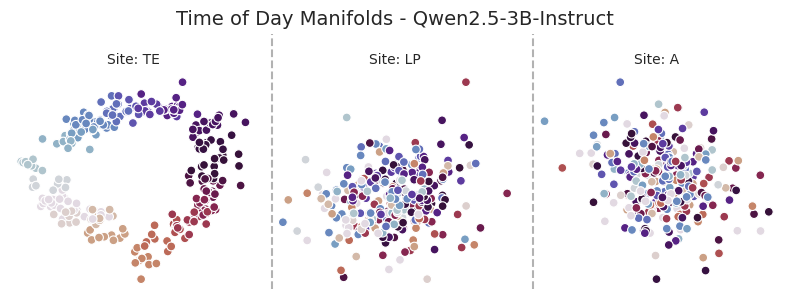

In [24]:
# Combined plots for time of day at three locations

import matplotlib.pyplot as plt
import pandas as pd
from time_stuff.plot import plot_activations_single
from time_stuff.utils import ActivationDataset



# Load dataset once
ad = ActivationDataset.load('results/Qwen2.5-3B-Instruct/time_of_day_3way.pt')

# Mapping of target column to display name
target2site = {
    'correct_time_expr': 'TE',
    'last_prompt_token': 'LP',
    'correct_answer': 'A',
}

# Target columns and corresponding layers
layers = [2, 9, 10]
target_cols = ['correct_time_expr', 'last_prompt_token', 'correct_answer']

# Create a 1x3 subplot layout with compact width
fig, axes = plt.subplots(1, 3, figsize=(8, 3))  # Adjust height as needed

for i, (layer, target_col) in enumerate(zip(layers, target_cols)):
    ax = axes[i]

    plot_activations_single(
        ad, 
        label_col='correct_time',
        target_col=target_col,
        label_col_str='correct_time',
        reduction_method='SMDS',
        layer=layer,
        ax=ax,
        manifold='circular',
        palette='twilight',
        preprocess_func=lambda x: pd.to_datetime(x).hour,
        annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%H:%M'),
        n_components=3,
        filter_incorrect=True,
        max_samples=1000,
    )

    ax.grid(False)
    ax.set_xlabel('')  # Remove axis labels if desired
    ax.set_ylabel('')
    ax.set_title(f'Site: {target2site[target_col]}', fontsize=10)

    # Clean plot
    ax.tick_params(axis='both', which='both', length=0)  # Remove ticks
    ax.set_xticks([])  # Remove x-ticks
    ax.set_yticks([])  # Remove y-ticks
    ax.spines['top'].set_visible(False)  # Remove top spine
    ax.spines['right'].set_visible(False)  # Remove right spine
    ax.spines['left'].set_visible(False)  # Remove left spine
    ax.spines['bottom'].set_visible(False)  # Remove bottom spine

# Add a compact suptitle
plt.suptitle('Time of Day Manifolds - Qwen2.5-3B-Instruct', fontsize=14)

# Layout adjustment
plt.tight_layout()

add_subplot_separators(fig, axes, direction='vertical', every_n=1, margin=(0.05, 0.9))
# plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle
plt.savefig('plots/time_of_day_combined.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)


### Shape manifolds

Layer: 6 - Score: 0.9225
Layer: 2 - Score: 0.9994
Layer: 5 - Score: 0.9988


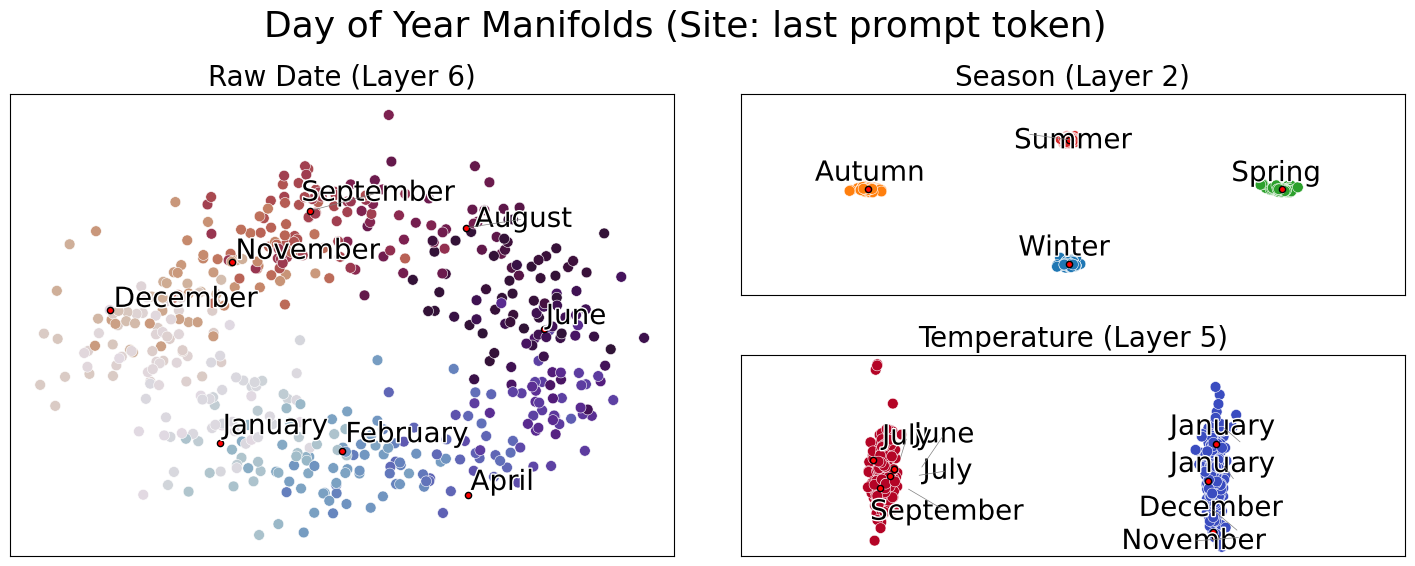

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from time_stuff.plot import plot_activations_single
from time_stuff.utils import ActivationDataset
import matplotlib.gridspec as gridspec
matplotlib.rcParams['svg.fonttype'] = 'none'

# Common figure with 3 horizontal subplots
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.3)

# Square left plot spans both rows
ax0 = fig.add_subplot(gs[:, 0])

# Right two plots
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

axes = [ax0, ax1, ax2]
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(left=False, bottom=False)

plt.suptitle('Day of Year Manifolds (Site: last prompt token)', fontsize=26, y=1.02)

# ----------------------------- Plot 1: Date (Day of Year) -----------------------------
ad1 = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')
plot_activations_single(
    ad1, 
    label_col='correct_date',
    target_col='last_prompt_token',
    label_col_str='correct_date',
    reduction_method='SMDS',
    layer=6,
    ax=axes[0],
    manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).day_of_year,
    annotations='centroids',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    annotation_fontsize=20,
    s=60,
    linewidth=0.4,
    n_components=3,
    n_annotations=8,
    filter_incorrect=True,
    max_samples=1000,
)
axes[0].grid(False)
axes[0].set_ylabel('Component 1')
axes[0].set_title('Raw Date (Layer 6)', fontsize=20)

# ----------------------------- Plot 2: Season -----------------------------
dict_season = {
    'spring': 'Spring',
    'summer': 'Summer',
    'autumn': 'Autumn',
    'fall': 'Autumn',
    'winter': 'Winter',
}
ad2 = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_season.pt')
plot_activations_single(
    ad2, 
    label_col='correct_season_label',
    target_col='last_prompt_token',
    label_col_str='correct_season',
    reduction_method='SMDS',
    layer=2,
    ax=axes[1],
    manifold='cluster',
    # palette='Set1',
    palette=sns.color_palette(['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e']),
    annotations='centroids',
    annotation_preprocess_func=lambda x: dict_season.get(x, x),
    annotation_fontsize=20,
    s=60,
    linewidth=0.4,
    n_components=3,
    components=(0, 2),
    filter_incorrect=True,
    max_samples=1000,
    annotation_offset=(-0.1, 0.05)  # Adjust offset for better visibility
)
axes[1].grid(False)
axes[1].set_xlabel('Component 0')
axes[1].set_title('Season (Layer 2)', fontsize=20)
axes[1].set_xlim(-0.8, 0.8)  # Adjust x-limits for better visibility
axes[1].set_ylim(-0.8, 0.8)  # Adjust y-limits for better visibility

# ----------------------------- Plot 3: Temperature -----------------------------
ad3 = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_temperature.pt')
plot_activations_single(
    ad3, 
    label_col='correct_temperature_label',
    target_col='last_prompt_token',
    label_col_str='correct_date',
    reduction_method='SMDS',
    layer=5,
    ax=axes[2],
    manifold='cluster',
    annotations='uniform',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    annotation_fontsize=20,
    s=60,
    linewidth=0.4,
    n_components=3,
    n_annotations=8,
    filter_incorrect=True,
    max_samples=1000,
    annotation_offset=(0.08,0)
)
axes[2].grid(False)
axes[2].set_title('Temperature (Layer 5)', fontsize=20)
axes[2].set_xlim(-1, 1)  

# ----------------------------- Finalize and Save -----------------------------
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.savefig('plots/date_manifold_combined.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)


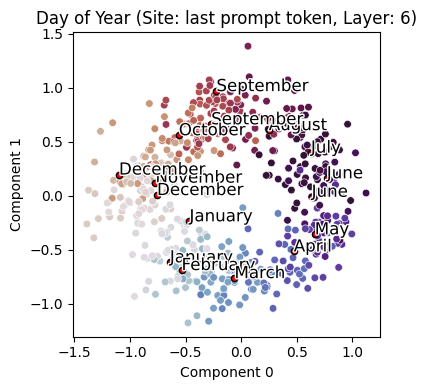

In [ ]:
from time_stuff.plot import plot_activations_single
import matplotlib.pyplot as plt
from time_stuff.utils import ActivationDataset
import numpy as np
import pandas as pd

ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')
layers = [6]

fig, ax = plt.subplots(figsize=(6, 6))
plot_activations_single(
    ad, 
    label_col='correct_date',
    target_col='last_prompt_token',
    label_col_str='correct_date',
    reduction_method='SMDS',
    layer=layers[0],
    ax=ax,
    manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).day_of_year,
    annotations='centroids',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=3,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,  # Limit the number of samples to 1000 for performance
)
ax.grid(False)
# Display
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('Day of Year (Site: last prompt token, Layer: 6)')
plt.tight_layout()
plt.savefig('plots/date_manifold.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

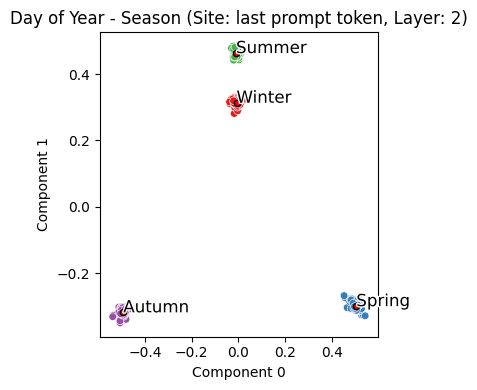

In [ ]:
from time_stuff.plot import plot_activations_single
import matplotlib.pyplot as plt
from time_stuff.utils import ActivationDataset
import numpy as np
import pandas as pd

dict_season = {
    'spring': 'Spring',
    'summer': 'Summer',
    'autumn': 'Autumn',
    'fall': 'Autumn',
    'winter': 'Winter',
}

ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_season.pt')
layers = [2]

fig, ax = plt.subplots(figsize=(6, 6))
plot_activations_single(
    ad, 
    label_col='correct_season_label',
    target_col='last_prompt_token',
    label_col_str='correct_season',
    reduction_method='SMDS',
    layer=layers[0],
    ax=ax,
    manifold='cluster',
    palette='Set1',
    # preprocess_func=lambda x: pd.to_datetime(x).month,
    annotations='centroids',
    annotation_preprocess_func=lambda x: dict_season.get(x, x),  # Map season to its name
    n_components=3,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,  # Limit the number of samples to 1000 for performance
)
ax.grid(False)
# Display
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('Day of Year - Season (Site: last prompt token, Layer: 2)')
plt.tight_layout()
plt.savefig('plots/date_season_manifold.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

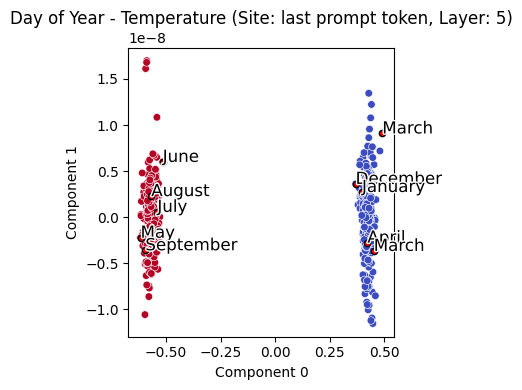

In [ ]:
from time_stuff.plot import plot_activations_single
import matplotlib.pyplot as plt
from time_stuff.utils import ActivationDataset
import numpy as np
import pandas as pd


ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way_temperature.pt')
layers = [5]
# plot_activations(ad, label_col='correct_temperature_label', layers=layers, reduction_method='SMDS', 
#                  save_path='plots/date_temperature.pdf',
#                  target_col='last_prompt_token', title='Day of Year - temperature (Site: last prompt token, Layer: 5)',
#                  label_col_str='correct_date', manifold='cluster', plots_per_row=2, annotations='uniform',
#                  annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'))

fig, ax = plt.subplots(figsize=(6, 6))
plot_activations_single(
    ad, 
    label_col='correct_temperature_label',
    target_col='last_prompt_token',
    label_col_str='correct_date',
    reduction_method='SMDS',
    layer=layers[0],
    ax=ax,
    manifold='cluster',
    palette='Set1',
    annotation_center_bias=0.0,
    # preprocess_func=lambda x: pd.to_datetime(x).month,
    annotations='uniform',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=3,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,  # Limit the number of samples to 1000 for performance
)
ax.grid(False)
# Display
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('Day of Year - Temperature (Site: last prompt token, Layer: 5)')
plt.tight_layout()
plt.savefig('plots/date_temperature_manifold.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

### Failure modes of other techniques

Layer: 6 - Score: 1.0000
Layer: 6 - Score: 8863.4228
Layer: 3 - Score: 0.9808


/tmp/ipykernel_559478/3085064279.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle


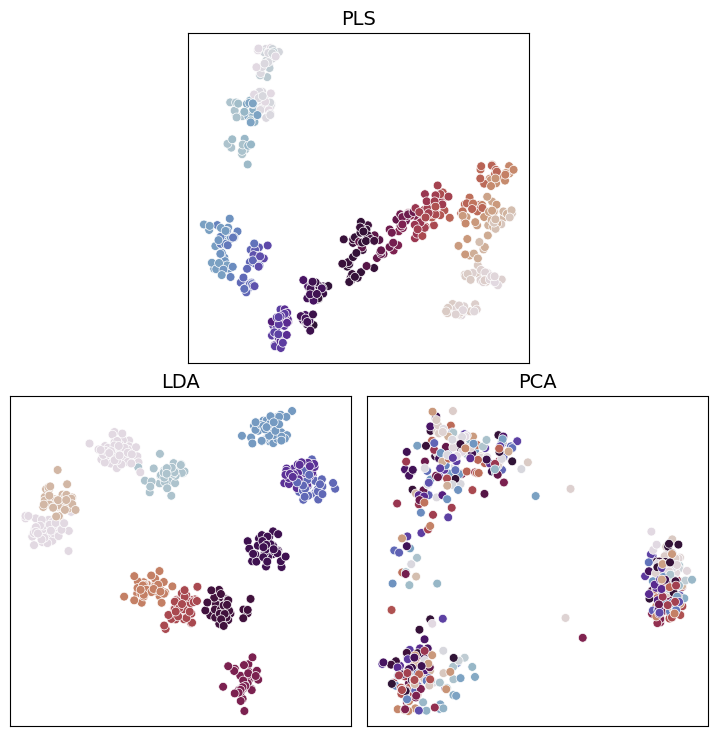

Layer: 3 - Score: 0.9657


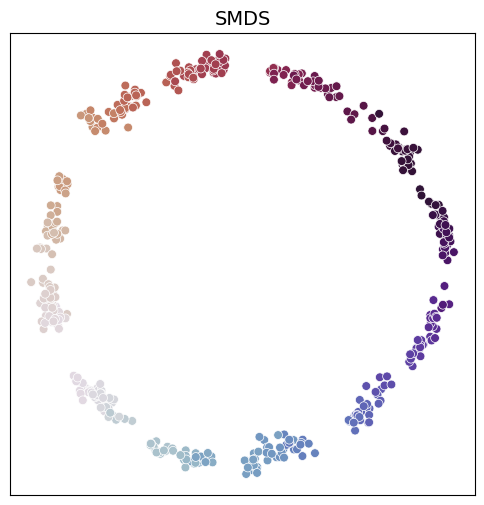

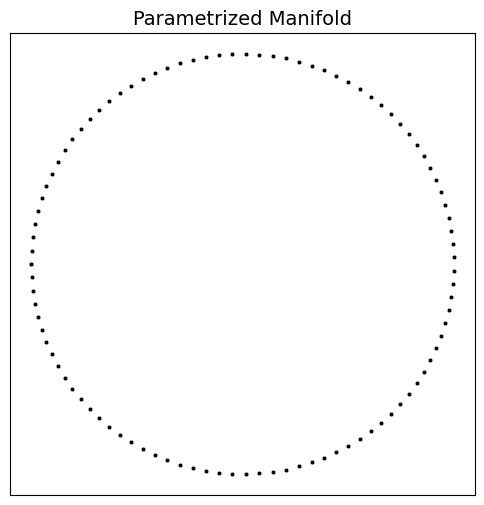

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import seaborn as sns
from time_stuff.plot import plot_activations_single
from time_stuff.utils import ActivationDataset, SupervisedMDS

def clean_scatterplot(ax):
    # 1. Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def get_triangular_subplots():
    fig = plt.figure(figsize=(9, 9))  # Square figure
    gs = gridspec.GridSpec(2, 4)      # 2 rows, 4 columns
    gs.update(wspace=0.1, hspace=0.1)  # Adjust spacing between subplots

    # Bottom row: two plots left and right
    ax1 = plt.subplot(gs[1, :2])     # Bottom left
    ax2 = plt.subplot(gs[1, 2:])     # Bottom right

    # Top row: one centered plot spanning the middle columns
    ax3 = plt.subplot(gs[0, 1:3])    # Top center

    # Optional: make sure aspect is square
    for ax in [ax1, ax2, ax3]:
        # ax.set_aspect('equal')
        clean_scatterplot(ax)
        

    return fig, [ax1, ax2, ax3]

def datetime_to_month(x):
    # Convert to datetime
    x = pd.to_datetime(x)
    # Get the month
    return x.month

# Common figure with 3 horizontal subplots
fig, axes = get_triangular_subplots()
# plt.suptitle('Day of Year Manifolds (Site: last prompt token)', fontsize=20)
ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')


# ----------------------------- Plot 1: Date (Day of Year) -----------------------------
plot_activations_single(
    ad, 
    label_col='correct_date',
    target_col='correct_date_str',
    label_col_str='correct_date',
    reduction_method='LDA',
    layer=6,
    ax=axes[0],
    # manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).month,
    # annotations='uniform',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=3,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,
)
axes[0].grid(False)
axes[0].set_title('LDA', fontsize=14)


# ----------------------------- Plot 2: Season -----------------------------
plot_activations_single(
    ad, 
    label_col='correct_date',
    target_col='correct_date_str',
    label_col_str='correct_date',
    reduction_method='PCA',
    layer=6,
    ax=axes[1],
    # manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).day_of_year,
    # annotations='uniform',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=3,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,
)

axes[1].grid(False)
axes[1].set_title('PCA', fontsize=14)
# axes[1].set_xlim(-0.8, 0.8)  # Adjust x-limits for better visibility
# axes[1].set_ylim(-0.8, 0.8)  # Adjust y-limits for better visibility

# ----------------------------- Plot 3: Temperature -----------------------------
plot_activations_single(
    ad, 
    label_col='correct_date',
    target_col='correct_date_str',#'last_prompt_token',correct_date_str
    label_col_str='correct_date',
    reduction_method='PLS',
    layer=3,
    ax=axes[2],
    # manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).day_of_year,
    # annotations='uniform',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=2,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,
)

axes[2].grid(False)
axes[2].set_title('PLS', fontsize=14)
# axes[2].set_xlim(-0.8, 0.8)  

# ----------------------------- Finalize and Save -----------------------------
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle
plt.savefig('plots/error_modes_combined.svg', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

# Make a separate plot for SMDS
fig, ax = plt.subplots(figsize=(6, 6))
plot_activations_single(
    ad, 
    label_col='correct_date',
    target_col='correct_date_str',#'last_prompt_token',correct_date_str
    label_col_str='correct_date',
    reduction_method='SMDS',
    layer=3,
    ax=ax,
    # manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).day_of_year,
    # annotations='uniform',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=2,
    return_fig=True,
    filter_incorrect=True,
    max_samples=1000,
)
clean_scatterplot(ax)
ax.grid(False)
ax.set_title('SMDS', fontsize=14)
plt.savefig('plots/smds_date_example.png', bbox_inches='tight', dpi=300)

# Make a separate plot for Y elements of the SMDS
fig, ax = plt.subplots(figsize=(6, 6))
y = np.linspace(0, 1, 100)
smds = SupervisedMDS(n_components=2, manifold='circular')
D = smds._compute_ideal_distances(y)
Y = smds._classical_mds(D)
sns.scatterplot(
    x=Y[:, 0], 
    y=Y[:, 1], 
    ax=ax, 
    s=10,
    color='black'
)
clean_scatterplot(ax)
ax.grid(False)
ax.set_title('Parametrized Manifold', fontsize=14)
plt.savefig('plots/parametrized_manifold.svg', bbox_inches='tight', dpi=300)



In [ ]:
# Make a separate plot for SMDS
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import seaborn as sns
from time_stuff.plot import plot_activations_single
from time_stuff.utils import ActivationDataset, SupervisedMDS

def clean_scatterplot(ax):
    # 1. Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])


ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_3way.pt')
fig, ax = plt.subplots(figsize=(6, 6))
plot_activations_single(
    ad, 
    label_col='correct_time',
    target_col='correct_time_expr',
    label_col_str='correct_time',
    reduction_method='SMDS',
    layer=3,
    ax=ax,
    # manifold='circular',
    palette='twilight',
    preprocess_func=lambda x: pd.to_datetime(x).hour,
    annotations='centroids',
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%H:%M'),
    n_components=2,
    filter_incorrect=True,
    max_samples=1000,
)
clean_scatterplot(ax)
ax.grid(False)
ax.set_title('SMDS', fontsize=14)
plt.savefig('plots/smds_tod_example.png', bbox_inches='tight', dpi=300)

KeyboardInterrupt: 

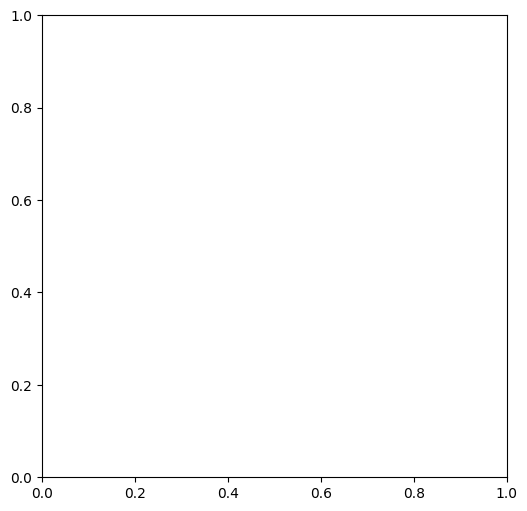

In [1]:
# Make a separate plot for SMDS
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import seaborn as sns
from time_stuff.plot import plot_activations_single
from time_stuff.utils import ActivationDataset, SupervisedMDS

def clean_scatterplot(ax):
    # 1. Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])


ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/periodic_3way.pt')
fig, ax = plt.subplots(figsize=(6, 6))
plot_activations_single(
    ad, 
    label_col='correct_period_length',
    target_col='correct_period_str',
    label_col_str='correct_period_str',
    reduction_method='SMDS',
    layer=7,
    ax=ax,
    manifold='log_linear',
    palette='flare',
    preprocess_func=lambda x: np.log(x),
    annotations='centroids',
    components=(1, 0),
    # annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    n_components=2,
    filter_incorrect=True,
    max_samples=1000,
)
clean_scatterplot(ax)
ax.grid(False)
ax.set_title('SMDS', fontsize=14)
plt.savefig('plots/smds_periodic_example.png', bbox_inches='tight', dpi=300)

    

### Accuracy Radar Plot

In [6]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt

def rgba(color_hex, alpha):
    """Convert a hex color to rgba string with given alpha."""
    from matplotlib.colors import to_rgba
    r, g, b, _ = to_rgba(color_hex)
    return f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})'

df = pd.read_csv('results/scores_scale.csv')
df = df.sort_values(by=['model_name', 'dataset_name', 'accuracy'], ascending=False)
df = df[['model_name', 'dataset_name', 'accuracy']].drop_duplicates()
df['dataset_name'] = df['dataset_name'].str.replace('_3way', '', regex=False)
# Replace only the last _ with newline
df['dataset_name'] = df['dataset_name'].str.replace(r'_(?!.*_)', '<br>', regex=True)

pivot_df = df.pivot(index='model_name', columns='dataset_name', values='accuracy').reset_index()
categories = pivot_df.columns[1:]  # skip model_name
fig = go.Figure()

tab10 = plt.cm.get_cmap('tab10').colors  # RGB tuples
fill_colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.2)' for r, g, b in tab10]
line_colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 1.0)' for r, g, b in tab10]

for i, row in pivot_df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[categories].tolist() + [row[categories[0]]],
        theta=categories.tolist() + [categories[0]],
        fill='toself',
        name=row['model_name'],
        fillcolor=fill_colors[i % len(line_colors)],
        line=dict(color=line_colors[i % len(line_colors)])
    ))


fig.update_layout(
    font=dict(family="sans-serif", size=12, color="black"),
    polar=dict(
        angularaxis=dict(rotation=90, direction="clockwise"),
        radialaxis=dict(visible=True, range=[0, 1.1], angle=90, linecolor=rgba('#ffffff', 0.0), tickangle=90, )
    ),
    title=dict(
        text="Model Accuracy",
        x=0.5,
        xanchor='center',
        yanchor='bottom',
        pad=dict(t=20)
    ),
    legend=dict(
        orientation="v",
        x=0.5,
        yanchor="top",
        xanchor="center",
        y=-0.1,
        font=dict(size=10),
        itemwidth=30
    ),
    margin=dict(l=0, r=0, t=40, b=40),
)

fig.show()
fig.write_image("plots/radar_plot_llama.pdf", scale=1, width=400, height=400)

/tmp/ipykernel_65649/1601017909.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [3]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt

def rgba(color_hex, alpha):
    """Convert a hex color to rgba string with given alpha."""
    from matplotlib.colors import to_rgba
    r, g, b, _ = to_rgba(color_hex)
    return f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})'

df = pd.read_csv('results/combined_scores.csv')
df = df.sort_values(by=['model_name', 'dataset_name', 'accuracy'], ascending=False)
df = df[['model_name', 'dataset_name', 'accuracy']].drop_duplicates()
df['dataset_name'] = df['dataset_name'].str.replace('_3way', '', regex=False)
# Replace only the last _ with newline
df['dataset_name'] = df['dataset_name'].str.replace(r'_(?!.*_)', '<br>', regex=True)

pivot_df = df.pivot(index='model_name', columns='dataset_name', values='accuracy').reset_index()
categories = pivot_df.columns[1:]  # skip model_name
fig = go.Figure()

tab10 = plt.cm.get_cmap('tab10').colors  # RGB tuples
fill_colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.2)' for r, g, b in tab10]
line_colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 1.0)' for r, g, b in tab10]

for i, row in pivot_df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[categories].tolist() + [row[categories[0]]],
        theta=categories.tolist() + [categories[0]],
        fill='toself',
        name=row['model_name'],
        fillcolor=fill_colors[i % len(line_colors)],
        line=dict(color=line_colors[i % len(line_colors)])
    ))


fig.update_layout(
    font=dict(family="sans-serif", size=12, color="black"),
    polar=dict(
        angularaxis=dict(rotation=90, direction="clockwise"),
        radialaxis=dict(visible=True, range=[0, 1.1], angle=90, linecolor=rgba('#ffffff', 0.0), tickangle=90, )
    ),
    title=dict(
        text="Model Accuracy",
        x=0.5,
        xanchor='center',
        yanchor='bottom',
        pad=dict(t=20)
    ),
    legend=dict(
        orientation="v",
        x=0.5,
        yanchor="top",
        xanchor="center",
        y=-0.1,
        font=dict(size=10),
        itemwidth=30
    ),
    margin=dict(l=0, r=0, t=40, b=40),
)

fig.show()
fig.write_image("plots/radar_plot_all.png", scale=1, width=400, height=400)

/tmp/ipykernel_65649/12008663.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



### More task examples

In [59]:
# Load all the datasets
import pandas as pd


datasets = [
    'date_3way',
    'date_3way_season',
    'date_3way_temperature',
    'duration_3way',
    'notable_3way',
    'time_of_day_3way',
    'time_of_day_3way_phase'
]

# Sample 3 examples from each dataset and organize them in a DataFrame
examples = []
for dataset in datasets:
    df = pd.read_csv(f'datasets/templates/{dataset}.csv')
    example = df.sample(2).reset_index(drop=True)
    example['dataset'] = dataset
    examples.append(example)
df_examples = pd.concat(examples, ignore_index=True)
df_examples['dataset'] = df_examples['dataset'].str.replace('_3way', '', regex=False)  # Remove _3way suffix for clarity
df_examples['dataset'] = df_examples['dataset'].mask(df_examples['dataset'].duplicated(), '')
# Print the examples
print(df_examples[['dataset', 'context']].to_latex(index=False, escape=False, header=False))



\begin{tabular}{ll}
\toprule
\midrule
date & Brandon donated clothes on the 29th of September. Bob donated clothes on the 31st of August. Jerry donated clothes on the 27th of September. The first person that donated clothes was \\
 & Matt visited a new city on the 22nd of February. Josh visited a new city on the 14th of February. Frank visited a new city on the 1st of March. The first person that visited a new city was \\
date_season & Emily mowed the lawn on the 8th of December. Blake mowed the lawn on the 30th of April. Walker mowed the lawn on the 27th of June. The only person that mowed the lawn in fall is \\
 & Rose painted a mural on the 16th of June. Robert painted a mural on the 13th of July. Martin painted a mural on the 27th of July. The only person that painted a mural in spring is \\
date_temperature & Richard left for vacation on the 25th of June. Neil left for vacation on the 22nd of December. April left for vacation on the 22nd of August. The only person that left for va

### 3D Plots

In [1]:
# Use plotly to visualize the SMDS manifold
from time_stuff.utils import ActivationDataset
from time_stuff.plot import plot_activations_single, plot_activations_plotly
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd



def through_earth_distance_matrix(y, radius=6371):
    lat_rad = np.radians(y[:, 0])
    lon_rad = np.radians(y[:, 1])

    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y_ = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)

    coords = np.stack([x, y_, z], axis=1)
    diffs = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    return np.linalg.norm(diffs, axis=2)

ad = ActivationDataset.load('results/gemma-2-2b-it/cities_3way.pt')
print(ad.get_accuracy())
fig, model, red_activations, labels = plot_activations_plotly(
    ad,
    label_col=['reference_lat', 'reference_lon'],
    target_col='reference_city',
    label_col_str='reference_city',
    reduction_method='SMDS',
    layer=20,
    n_components=2,
    components=(0,1),
    manifold='euclidean',
    plot_test=True,
    filter_incorrect=False,
    max_samples=2000,
    color_by='reference_lon',  # or 'correct_country'
    title="SMDS Manifold of Cities (Plotly)"
)

fig.show()



0.508
Layer: 20 - Score: 0.8002


In [1]:
# Use plotly to visualize the SMDS manifold
from time_stuff.utils import ActivationDataset
from time_stuff.plot import plot_activations_single, plot_activations_plotly
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd


ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/date_3way.pt')
fig, model, red_activations, labels = plot_activations_plotly(
    ad,
    label_col='correct_date',
    target_col='last_prompt_token',
    label_col_str='correct_date',
    reduction_method='SMDS',
    layer=20,
    n_components=3,
    components=(0,1,2),
    manifold='helix',
    plot_test=True,
    filter_incorrect=True,
    max_samples=2000,
    annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%B'),
    preprocess_func=lambda x: pd.to_datetime(x).month,
)

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/time_of_day_3way.pt')
# fig, model, red_activations, labels = plot_activations_plotly(
#     ad,
#     label_col='correct_time',
#     target_col='correct_time_expr',
#     label_col_str='correct_time',
#     reduction_method='SMDS',
#     layer=7,
#     n_components=4,
#     components=(0, 1, 3),
#     manifold='circular',
#     plot_test=True,
#     filter_incorrect=True,
#     max_samples=2000,
#     annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%H:%M'),
#     preprocess_func=lambda x: pd.to_datetime(x).hour,
# )

# ad = ActivationDataset.load('results/Llama-3.2-3B-Instruct/notable_3way.pt')
# fig, model, red_activations, labels = plot_activations_plotly(
#     ad,
#     label_col='correct_date',
#     target_col='last_prompt_token',
#     label_col_str='correct_date',
#     reduction_method='PLS',
#     layer=7,
#     n_components=3,
#     components=(0, 1, 2),
#     manifold='log_semicircular',
#     plot_test=True,
#     filter_incorrect=True,
#     max_samples=2000,
#     annotation_preprocess_func=lambda x: pd.to_datetime(x).strftime('%Y'),
#     preprocess_func=lambda x: pd.to_datetime(x).year - 2023,
# )


fig.show()



Layer: 20 - Score: 0.9087


### Other

In [13]:
# Same but with only best manifold at last layer

import pandas as pd
import numpy as np

df = pd.read_csv('results/scores/combined_scores.csv')

# Filter dataset
df = df[df['n_components'] == 3]
df = df[df['layer'] > 2]
df = df[df['target_col'] == 'correct_answer']  # Only consider last prompt token
df = df[(df['dataset_name'] != 'duration_3way') | (df['preprocess_func'].isna())]  # Exclude duration_3way dataset if preprocess_func is NaN


# df = df[df['target_col'] == 'last_prompt_token']
# df = df[~df['manifold'].isin(['log_semicircular'])]

# df = df[~df['dataset_name'].isin(['date_3way_season', 'date_3way_temperature', 'time_of_day_3way_phase'])]
df = df[~df['dataset_name'].isin(['date_3way_temperature'])] # Stress computation breaks down for binary datasets - an indicator of structure in itself
df['score'] = - np.log(1 - df['score'])  # Convert score to stress (1 - score)

# Step 0: Rename
df['model_name'] = df['model_name'].str.split('/').str[-1]
df['dataset_name'] = df['dataset_name'].str.replace('_3way', '', regex=False).replace('_','\\_')

# Step 1: For each (model, dataset, manifold), get the best (layer, score)
best_per_manifold = df.loc[df.groupby(['model_name', 'dataset_name'])['score'].idxmax()]

# Step 2: For each (model, dataset), get all the scores for the best manifold
best_manifold = df.merge(
    best_per_manifold[['model_name', 'dataset_name', 'manifold']],
    on=['model_name', 'dataset_name', 'manifold'],
    suffixes=('', '_best')
)

# Step 3: For each (model, dataset), get the last layer
best_manifold = best_manifold.loc[best_manifold.groupby(['model_name', 'dataset_name'])['layer'].idxmax()]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    top1 = top_k[top_k['rank'] == 1]
    print(best_manifold[['score', 'layer', 'accuracy']].corr(method='spearman'))
    print(best_manifold.to_string(index=False))
    # print(pivoted_models_with_avg.to_latex(index=False, escape=False, float_format="%.3f", column_format='lccccccccc'))




# Idea: Control for the layers -> partial correlation, controlled regression


KeyboardInterrupt: 

In [1]:
# Same but with circular/discrete/linear task types

import pandas as pd

df = pd.read_csv('results/scores/all_scores.csv')

# Filter dataset
df = df[df['target_col'] == 'correct_answer']
df = df[~df['manifold'].isin(['log_semicircular', 'semicircular'])]
df['task_type'] = df['dataset_name'].map({
    'date_3way': 'cyclic',
    'date_3way_season': 'discrete',
    'date_3way_temperature': 'discrete',
    'notable_3way': 'linear',
    'periodic_3way': 'linear',
    'time_of_day_3way': 'cyclic',
    'time_of_day_3way_phase': 'discrete',
})

# Average scores for each task type
df = df.groupby(['model_name', 'task_type', 'manifold', 'layer']).agg({
    'score': 'mean',
    'accuracy': 'mean',
}).reset_index()

# df = df[~df['dataset_name'].isin(['date_3way_season', 'date_3way_temperature', 'time_of_day_3way_phase'])]

# Step 1: For each (model, dataset, manifold), get the best (layer, score)
best_per_manifold = df.loc[df.groupby(['model_name', 'task_type', 'manifold'])['score'].idxmax()]

# Step 2: For each (model, dataset), get top 3 **distinct** manifolds based on their best layer scores
top_k = best_per_manifold.groupby(['model_name', 'task_type'], group_keys=False).apply(
    lambda g: g.nlargest(3, 'score')
)

# Step 3: Add rank (1=best manifold, etc.)
top_k['rank'] = top_k.groupby(['model_name', 'task_type']).cumcount() + 1

# Optional: pivot for easier comparison
pivoted = top_k.pivot_table(
    index=['model_name', 'task_type', 'accuracy'],
    columns='rank',
    values=['manifold', 'score'],
    aggfunc='first'
)

# Flatten multi-index columns
pivoted.columns = [f'{col[0]}_top{col[1]}' for col in pivoted.columns]
pivoted = pivoted.reset_index()

# Print correlation of best scores
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    top1 = top_k[top_k['rank'] == 1]
    print(top1[['score', 'layer', 'accuracy']].corr(method='pearson'))
    print(pivoted.to_string(index=False))


             score     layer  accuracy
score     1.000000 -0.722217  0.306084
layer    -0.722217  1.000000 -0.532382
accuracy  0.306084 -0.532382  1.000000
                      model_name task_type  accuracy manifold_top1     manifold_top2     manifold_top3  score_top1  score_top2  score_top3
        Qwen/Qwen2.5-3B-Instruct    cyclic  0.275143      circular discrete_circular         euclidean    0.728382    0.656962    0.630230
        Qwen/Qwen2.5-3B-Instruct  discrete  0.271167       cluster        log_linear discrete_circular    0.910919    0.893032    0.888909
        Qwen/Qwen2.5-3B-Instruct    linear  0.318000    log_linear         euclidean          circular    0.839609    0.694651    0.691617
            google/gemma-2-2b-it    cyclic  0.222502      circular discrete_circular         euclidean    0.782672    0.720969    0.681318
            google/gemma-2-2b-it  discrete  0.319833    log_linear           cluster         euclidean    0.952216    0.949933    0.949766
          

/tmp/ipykernel_550726/2825161325.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_k = best_per_manifold.groupby(['model_name', 'task_type'], group_keys=False).apply(


In [ ]:
# Relative stress wrt semicircular manifold
import pandas as pd

df = pd.read_csv('results/scores/all_scores.csv')

# Filter to correct target only
df = df[df['target_col'] == 'correct_answer']
# You no longer want to exclude semicircular — keep it for baseline comparisons
df = df[~df['manifold'].isin(['log_semicircular'])]

# Optionally exclude some datasets
df = df[~df['dataset_name'].isin(['date_3way_temperature'])]

# Step 1: Get best score per (model, dataset, manifold)
best_per_manifold = df.loc[df.groupby(['model_name', 'dataset_name', 'manifold'])['score'].idxmax()]

# Step 2: Extract best 'semicircular' score per model and dataset
semicircular_baseline = best_per_manifold[best_per_manifold['manifold'] == 'semicircular']
semicircular_baseline = semicircular_baseline[['model_name', 'dataset_name', 'score']]
semicircular_baseline = semicircular_baseline.rename(columns={'score': 'semicircular_score'})

# Step 3: Merge semicircular baseline back into the dataframe
best_with_baseline = best_per_manifold.merge(semicircular_baseline, on=['model_name', 'dataset_name'], how='left')

# Step 4: Compute score difference (or ratio) from semicircular
# best_with_baseline['score_relative'] = best_with_baseline['score'] - best_with_baseline['semicircular_score']
# Alternatively, for ratio:
best_with_baseline['score_relative'] = best_with_baseline['score'] / best_with_baseline['semicircular_score']

# Step 5: Get top 3 manifolds by relative improvement
top_k = best_with_baseline.groupby(['model_name', 'dataset_name'], group_keys=False).apply(
    lambda g: g.nlargest(3, 'score_relative')
)

# Step 6: Add rank
top_k['rank'] = top_k.groupby(['model_name', 'dataset_name']).cumcount() + 1

# Step 7: Pivot for comparison
pivoted = top_k.pivot_table(
    index=['dataset_name', 'model_name', 'accuracy'],
    columns='rank',
    values=['manifold', 'score', 'score_relative'],
    aggfunc='first'
)

# Flatten multi-index columns
pivoted.columns = [f'{col[0]}_top{col[1]}' for col in pivoted.columns]
pivoted = pivoted.reset_index()

# Reorder columns for readability
pivoted = pivoted[['dataset_name', 'model_name', 'accuracy'] +
                  ['manifold_top1', 'score_top1', 'score_relative_top1',
                   'manifold_top2', 'score_top2', 'score_relative_top2',
                   'manifold_top3', 'score_top3', 'score_relative_top3']]

# Print Spearman correlations of top1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    top1 = top_k[top_k['rank'] == 1]
    print(top1[['score', 'score_relative', 'layer', 'accuracy']].corr(method='spearman'))
    print(pivoted.to_string(index=False))


                   score  score_relative     layer  accuracy
score           1.000000        0.353186 -0.353672  0.065015
score_relative  0.353186        1.000000  0.507703  0.053609
layer          -0.353672        0.507703  1.000000 -0.279215
accuracy        0.065015        0.053609 -0.279215  1.000000
          dataset_name                       model_name  accuracy manifold_top1  score_top1  score_relative_top1     manifold_top2  score_top2  score_relative_top2     manifold_top3  score_top3  score_relative_top3
             date_3way         Qwen/Qwen2.5-3B-Instruct  0.362952      circular    0.776894             1.052435      semicircular    0.738187             1.000000 discrete_circular    0.731766             0.991302
             date_3way             google/gemma-2-2b-it  0.376004      circular    0.885746             1.055001 discrete_circular    0.844970             1.006433      semicircular    0.839569             1.000000
             date_3way meta-llama/Llama-3.2-3B-Ins

/tmp/ipykernel_57856/3671880372.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_k = best_with_baseline.groupby(['model_name', 'dataset_name'], group_keys=False).apply(


In [ ]:
df = pd.read_csv('results/scores/all_scores.csv')

df = df[df['target_col'] == 'correct_answer']
# df = df[df['target_col'] == 'last_prompt_token']
df = df[~df['manifold'].isin(['log_semicircular','semicircular'])]
df = df[~df['dataset_name'].isin(['date_3way_season','date_3way_temperature', 'time_of_day_3way_phase'])]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # print(df.groupby(['model_name', 'dataset_name', 'manifold']).max('score'))
    best_rows = df.loc[df.groupby(['model_name', 'dataset_name'])['score'].idxmax()]
    best_scores = best_rows[['model_name', 'dataset_name', 'layer', 'manifold', 'score', 'accuracy']]
    print(best_scores[['score', 'layer', 'accuracy']].corr(method='spearman'))
    print(best_scores.to_string())



             score     layer  accuracy
score     1.000000 -0.073555 -0.041958
layer    -0.073555  1.000000 -0.045534
accuracy -0.041958 -0.045534  1.000000
                            model_name      dataset_name  layer   manifold     score  accuracy
2627          Qwen/Qwen2.5-3B-Instruct         date_3way     36   circular  0.731766  0.362952
1566          Qwen/Qwen2.5-3B-Instruct      notable_3way     19  euclidean  0.758699  0.316000
1458          Qwen/Qwen2.5-3B-Instruct     periodic_3way     19  euclidean  0.944968  0.320000
1245          Qwen/Qwen2.5-3B-Instruct  time_of_day_3way     22  euclidean  0.724474  0.187333
1645              google/gemma-2-2b-it         date_3way     26   circular  0.844970  0.376004
423               google/gemma-2-2b-it      notable_3way      8  euclidean  0.760677  0.578000
354               google/gemma-2-2b-it     periodic_3way     17  euclidean  0.963879  0.136250
194               google/gemma-2-2b-it  time_of_day_3way     13  euclidean  0.788127

In [ ]:
df = pd.read_csv('results/scores/all_scores.csv')
# Group by model_name and average the scores
df = df[df['target_col'] == 'correct_answer']
# df = df[~df['manifold'].isin(['log_semicircular','semicircular'])]
# df = df.groupby(['model_name', 'dataset_name'])
df[['layer','score']].corr(method='spearman')

,layer,score
layer,1.000000,0.222244
score,0.222244,1.000000


In [ ]:
df = pd.read_csv('results/scores/all_scores.csv')

df = df[df['target_col'] == 'correct_answer']
# df = df[df['target_col'] == 'last_prompt_token']
df = df[~df['manifold'].isin(['log_semicircular','semicircular'])]
df = df[~df['dataset_name'].isin(['date_3way_season','date_3way_temperature', 'time_of_day_3way_phase'])]

# Average over layers
df = df.groupby(['model_name', 'dataset_name', 'manifold']).agg(
    score=('score', 'mean'),
    accuracy=('accuracy', 'mean')
).reset_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # print(df.to_string())
    # print(df.groupby(['model_name', 'dataset_name', 'manifold']).max('score'))
    best_rows = df.loc[df.groupby(['model_name', 'dataset_name'])['score'].idxmax()]
    best_scores = best_rows[['model_name', 'dataset_name','manifold', 'score', 'accuracy']]
    print(best_scores[['score', 'accuracy']].corr(method='spearman'))
    print(best_scores.to_string())

             score  accuracy
score     1.000000  0.230769
accuracy  0.230769  1.000000
                          model_name      dataset_name    manifold     score  accuracy
0           Qwen/Qwen2.5-3B-Instruct         date_3way    circular  0.606929  0.362952
4           Qwen/Qwen2.5-3B-Instruct      notable_3way   euclidean  0.682770  0.316000
7           Qwen/Qwen2.5-3B-Instruct     periodic_3way   euclidean  0.855611  0.320000
9           Qwen/Qwen2.5-3B-Instruct  time_of_day_3way    circular  0.504870  0.187333
12              google/gemma-2-2b-it         date_3way    circular  0.632013  0.376004
16              google/gemma-2-2b-it      notable_3way   euclidean  0.665328  0.578000
20              google/gemma-2-2b-it     periodic_3way  log_linear  0.901756  0.136250
21              google/gemma-2-2b-it  time_of_day_3way    circular  0.484924  0.069000
24  meta-llama/Llama-3.2-3B-Instruct         date_3way    circular  0.705308  0.808735
28  meta-llama/Llama-3.2-3B-Instruct      n

In [2]:
from time_stuff.utils import ActivationDataset
import pandas as pd

ad = ActivationDataset.load('debug.pt', model_name='meta-llama/Llama-3.1-70B-Instruct')
print(ad.get_metadata_df().head())

KeyboardInterrupt: 